In [2]:
#brats20-dataset-training-validation
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' 
}


VOLUME_SLICES = 100 
VOLUME_START_AT = 22 

In [3]:
TRAIN_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
VALIDATION_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

In [4]:
import os
import numpy as np
import cv2
import tensorflow as tf
import nibabel as nib
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import CSVLogger, ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split

In [5]:

def dice_coef(y_true, y_pred, smooth=1e-6):
    class_num = y_true.shape[-1]  
    total_dice = 0.0
    for i in range(class_num):
        y_true_f = tf.keras.layers.Flatten()(y_true[..., i])
        y_pred_f = tf.keras.layers.Flatten()(y_pred[..., i])
        y_true_f = tf.cast(y_true_f, tf.float32)
        y_pred_f = tf.cast(y_pred_f, tf.float32)
        intersection = tf.reduce_sum(y_true_f * y_pred_f)
        union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
        dice = (2. * intersection + smooth) / (union + smooth)
        total_dice += dice
    return total_dice / class_num


def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    y_true_f = K.cast(y_true, 'float32')
    y_pred_f = K.cast(y_pred, 'float32')
    intersection = K.sum(y_true_f[:, :, :, 1] * y_pred_f[:, :, :, 1])
    return (2. * intersection + epsilon) / (K.sum(y_true_f[:, :, :, 1]) + K.sum(y_pred_f[:, :, :, 1]) + epsilon)


def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    y_true_f = K.cast(y_true, 'float32')
    y_pred_f = K.cast(y_pred, 'float32')
    intersection = K.sum(y_true_f[:, :, :, 2] * y_pred_f[:, :, :, 2])
    return (2. * intersection + epsilon) / (K.sum(y_true_f[:, :, :, 2]) + K.sum(y_pred_f[:, :, :, 2]) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    y_true_f = K.cast(y_true, 'float32')
    y_pred_f = K.cast(y_pred, 'float32')
    intersection = K.sum(y_true_f[:, :, :, 3] * y_pred_f[:, :, :, 3])
    return (2. * intersection + epsilon) / (K.sum(y_true_f[:, :, :, 3]) + K.sum(y_pred_f[:, :, :, 3]) + epsilon)

def precision(y_true, y_pred):
    y_true_f = K.cast(K.flatten(y_true), 'float32')
    y_pred_f = K.cast(K.flatten(y_pred), 'float32')
    true_positives = K.sum(K.round(K.clip(y_true_f * y_pred_f, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred_f, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())


def sensitivity(y_true, y_pred):
    y_true_f = K.cast(K.flatten(y_true), 'float32')
    y_pred_f = K.cast(K.flatten(y_pred), 'float32')
    true_positives = K.sum(K.round(K.clip(y_true_f * y_pred_f, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true_f, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    y_true_f = K.cast(K.flatten(y_true), 'float32')
    y_pred_f = K.cast(K.flatten(y_pred), 'float32')
    true_negatives = K.sum(K.round(K.clip((1 - y_true_f) * (1 - y_pred_f), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true_f, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [6]:
IMG_SIZE=128

In [7]:
def conv_block(inputs, filters, kernel_size, activation, padding, kernel_initializer):
    
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding, kernel_initializer=kernel_initializer)(inputs)
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding, kernel_initializer=kernel_initializer)(conv)
    return conv

def upsampling_block(inputs, skip_connection, filters, kernel_size, activation, padding, kernel_initializer):
    
    up = Conv2D(filters, kernel_size, activation=activation, padding=padding, kernel_initializer=kernel_initializer)(UpSampling2D(size=(2, 2))(inputs))
    merge = concatenate([skip_connection, up], axis=3)
    conv = conv_block(merge, filters, kernel_size, activation, padding, kernel_initializer)
    return conv

def build_unet(inputs, ker_init, dropout):
    
    conv1 = conv_block(inputs, 32, 3, activation='relu', padding='same', kernel_initializer=ker_init)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = conv_block(pool1, 64, 3, activation='relu', padding='same', kernel_initializer=ker_init)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = conv_block(pool2, 128, 3, activation='relu', padding='same', kernel_initializer=ker_init)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = conv_block(pool3, 256, 3, activation='relu', padding='same', kernel_initializer=ker_init)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

  
    conv5 = conv_block(pool4, 512, 3, activation='relu', padding='same', kernel_initializer=ker_init)
    drop5 = Dropout(dropout)(conv5)

  
    conv6 = upsampling_block(drop5, conv4, 256, 2, activation='relu', padding='same', kernel_initializer=ker_init)
    conv7 = upsampling_block(conv6, conv3, 128, 2, activation='relu', padding='same', kernel_initializer=ker_init)
    conv8 = upsampling_block(conv7, conv2, 64, 2, activation='relu', padding='same', kernel_initializer=ker_init)
    conv9 = upsampling_block(conv8, conv1, 32, 2, activation='relu', padding='same', kernel_initializer=ker_init)

    conv10 = Conv2D(4, (1, 1), activation='softmax')(conv9)

    return Model(inputs=inputs, outputs=conv10)

In [8]:
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model = build_unet(input_layer, 'he_normal', 0.2)
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, 
                         specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing] )


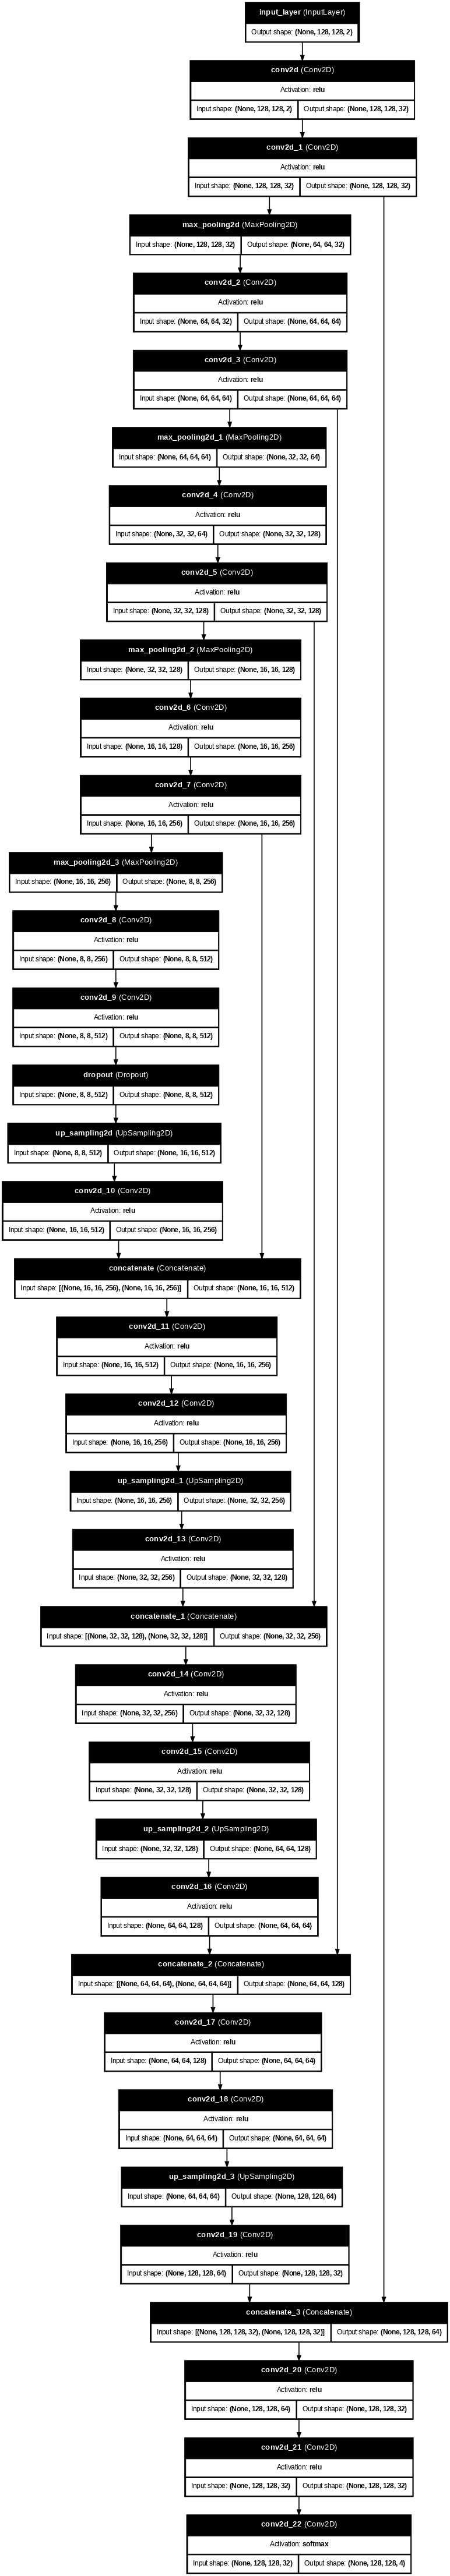

In [9]:
plot_model(
    model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=60,
    show_layer_activations=True
)

In [10]:

train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]


ill_formatted_dir = os.path.join(TRAIN_DATASET_PATH, 'BraTS20_Training_355')
if ill_formatted_dir in train_and_val_directories:
    train_and_val_directories.remove(ill_formatted_dir)

def pathListIntoIds(dir_list):
    return [os.path.basename(d) for d in dir_list]

train_and_test_ids = pathListIntoIds(train_and_val_directories)


train_test_ids, val_ids = train_test_split(train_and_test_ids, test_size=0.2)


train_ids, test_ids = train_test_split(train_test_ids, test_size=0.15)

print(f"Training IDs: {train_ids}")
print(f"Validation IDs: {val_ids}")
print(f"Test IDs: {test_ids}")

Training IDs: ['BraTS20_Training_271', 'BraTS20_Training_147', 'BraTS20_Training_177', 'BraTS20_Training_352', 'BraTS20_Training_261', 'BraTS20_Training_168', 'BraTS20_Training_234', 'BraTS20_Training_166', 'BraTS20_Training_122', 'BraTS20_Training_242', 'BraTS20_Training_075', 'BraTS20_Training_196', 'BraTS20_Training_061', 'BraTS20_Training_092', 'BraTS20_Training_171', 'BraTS20_Training_218', 'BraTS20_Training_192', 'BraTS20_Training_095', 'BraTS20_Training_246', 'BraTS20_Training_336', 'BraTS20_Training_275', 'BraTS20_Training_005', 'BraTS20_Training_072', 'BraTS20_Training_359', 'BraTS20_Training_054', 'BraTS20_Training_062', 'BraTS20_Training_241', 'BraTS20_Training_078', 'BraTS20_Training_158', 'BraTS20_Training_256', 'BraTS20_Training_100', 'BraTS20_Training_012', 'BraTS20_Training_193', 'BraTS20_Training_050', 'BraTS20_Training_304', 'BraTS20_Training_240', 'BraTS20_Training_117', 'BraTS20_Training_108', 'BraTS20_Training_320', 'BraTS20_Training_279', 'BraTS20_Training_008', '

In [11]:
print(len(train_ids),len(val_ids),len(test_ids))

249 74 45


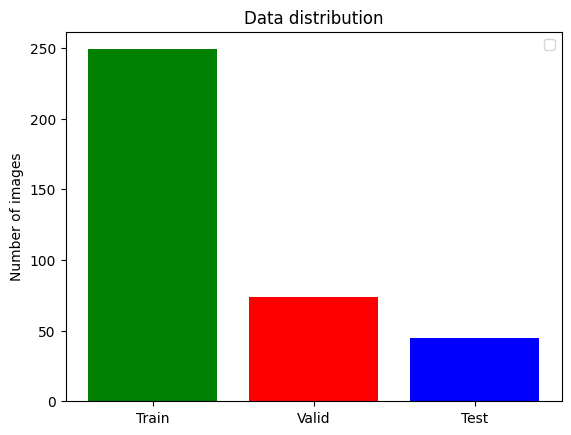

In [12]:
import matplotlib.pyplot as plt

def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()
    
showDataLayout()

In [13]:
class DataGenerator(Sequence):
    
    def __init__(self, list_IDs, dim=(IMG_SIZE, IMG_SIZE), batch_size=1, n_channels=2, shuffle=True):
    
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
    
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
    
    
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

    
        Batch_ids = [self.list_IDs[k] for k in indexes]

    
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
    
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
    
    
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, self.n_channels))
        Y = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, 4))

    
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            try:
    
                flair = nib.load(os.path.join(case_path, f'{i}_flair.nii')).get_fdata()
                ce = nib.load(os.path.join(case_path, f'{i}_t1ce.nii')).get_fdata()
                t1 = nib.load(os.path.join(case_path, f'{i}_t1.nii')).get_fdata()
                t2= nib.load(os.path.join(case_path, f'{i}_t2.nii')).get_fdata()
                seg = nib.load(os.path.join(case_path, f'{i}_seg.nii')).get_fdata()

               
                for j in range(VOLUME_SLICES):
                  
                    if j + VOLUME_START_AT >= flair.shape[2] or j + VOLUME_START_AT >= ce.shape[2] or j + VOLUME_START_AT >= t1.shape[2] or j + VOLUME_START_AT >= t2.shape[2]:
                        continue
                    
               
                    X[j + VOLUME_SLICES * c, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                    X[j + VOLUME_SLICES * c, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                   
                   
                    
                    y_slice = seg[:, :, j + VOLUME_START_AT]
                    y_slice = np.where(y_slice == 4, 3, y_slice)  # Convert 4 to 3
                    mask = tf.one_hot(y_slice, 4)
                    mask = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))

                    Y[j + VOLUME_SLICES * c] = mask

            except Exception as e:
                print(f"Error loading or processing files for ID {i}: {e}")

        return X / (np.max(X) + 1e-8), Y 

# Create generators
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

In [14]:
csv_logger = CSVLogger('training.log', separator=',', append=False)


callbacks = [
      tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
                               patience=8, verbose=1, mode='auto'),
      tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                               patience=2, min_lr=0.000001, verbose=1),
      csv_logger
      ]

In [15]:

K.clear_session()
history = model.fit(
    training_generator,
    validation_data=valid_generator,
    epochs=40,
    callbacks=callbacks    
)
model.save('Brats_Seg.h5')

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


249/249 ━━━━━━━━━━━━━━━━━━━━ 485s 2s/step - accuracy: 0.9608 - dice_coef: 0.2484 - dice_coef_edema: 0.0358 - dice_coef_enhancing: 0.0121 - dice_coef_necrotic: 0.0135 - loss: 0.3142 - mean_io_u: 0.4800 - precision: 0.9586 - sensitivity: 0.8965 - specificity: 0.9948 - val_accuracy: 0.9827 - val_dice_coef: 0.2839 - val_dice_coef_edema: 0.0768 - val_dice_coef_enhancing: 0.0361 - val_dice_coef_necrotic: 0.0361 - val_loss: 0.0685 - val_mean_io_u: 0.5000 - val_precision: 0.9828 - val_sensitivity: 0.9826 - val_specificity: 0.9943 - learning_rate: 0.0010
Epoch 2/40
249/249 ━━━━━━━━━━━━━━━━━━━━ 298s 1s/step - accuracy: 0.9838 - dice_coef: 0.2866 - dice_coef_edema: 0.0835 - dice_coef_enhancing: 0.0418 - dice_coef_necrotic: 0.0350 - loss: 0.0669 - mean_io_u: 0.4997 - precision: 0.9854 - sensitivity: 0.9822 - specificity: 0.9951 - val_accuracy: 0.9827 - val_dice_coef: 0.2638 - val_dice_coef_edema: 0.0403 - val_dice_coef_enhancing: 0.0138 - val_dice_coef_necrotic: 0.0113 - val_loss: 0.0844 - val_mea

Evaluate the Model on Test Data

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step


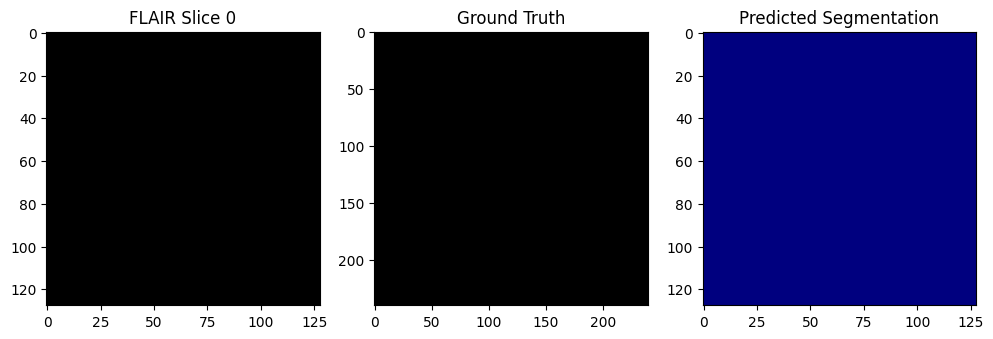

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


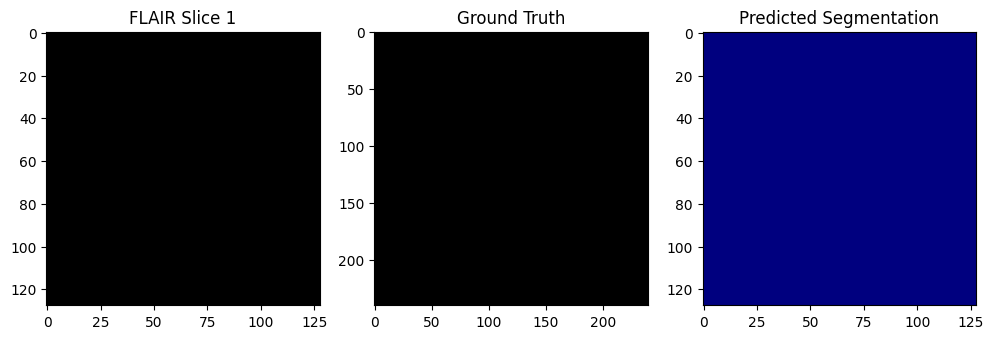

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


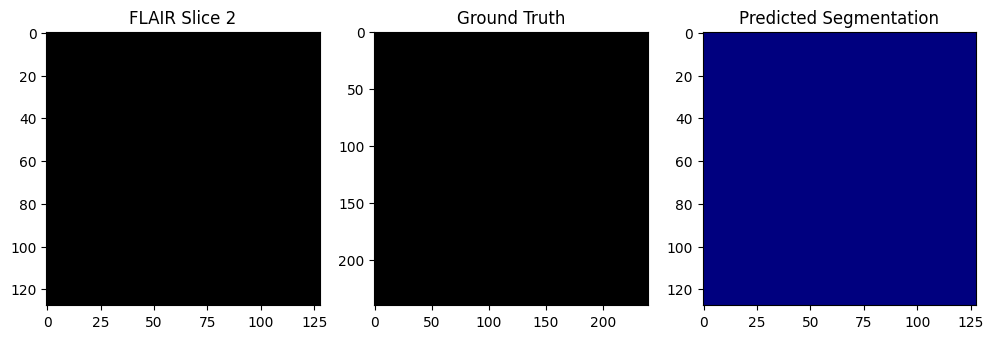

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


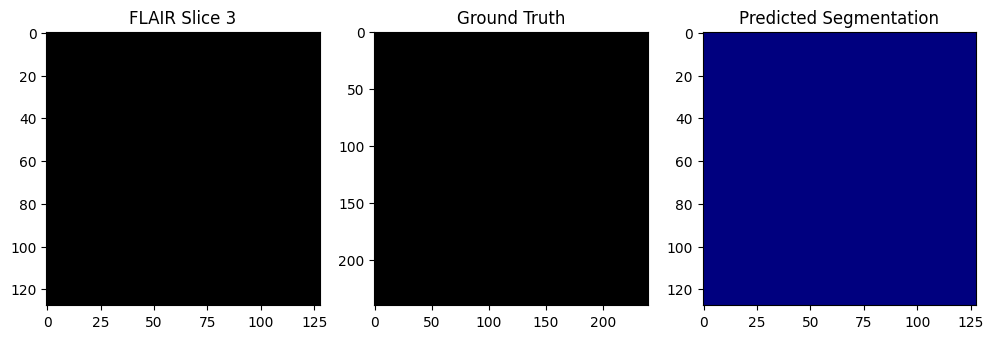

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


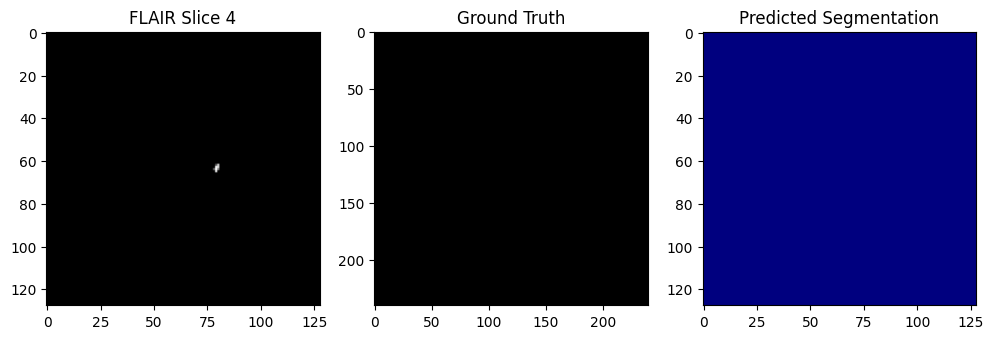

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


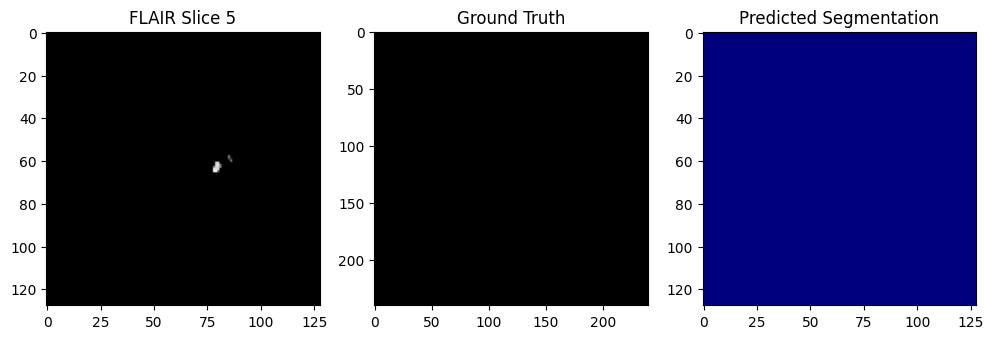

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


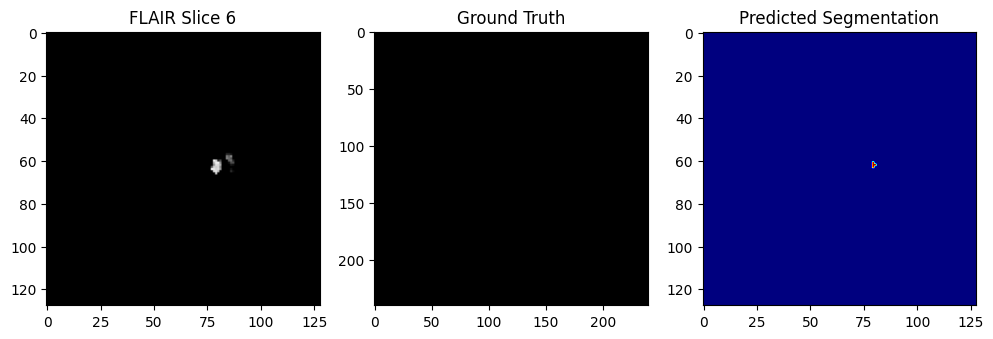

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


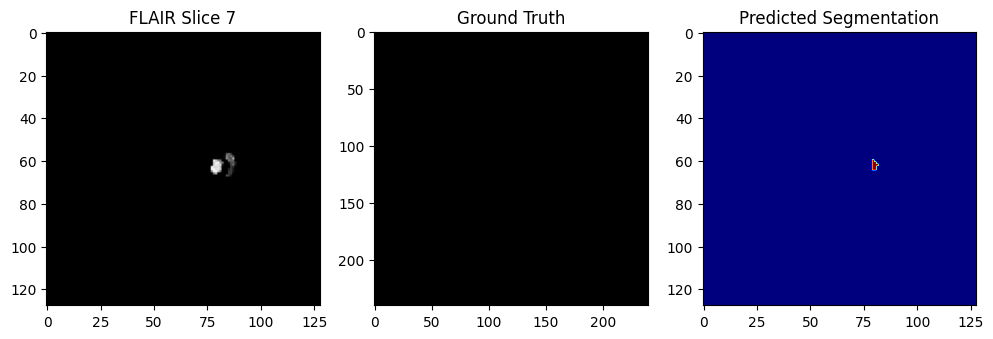

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


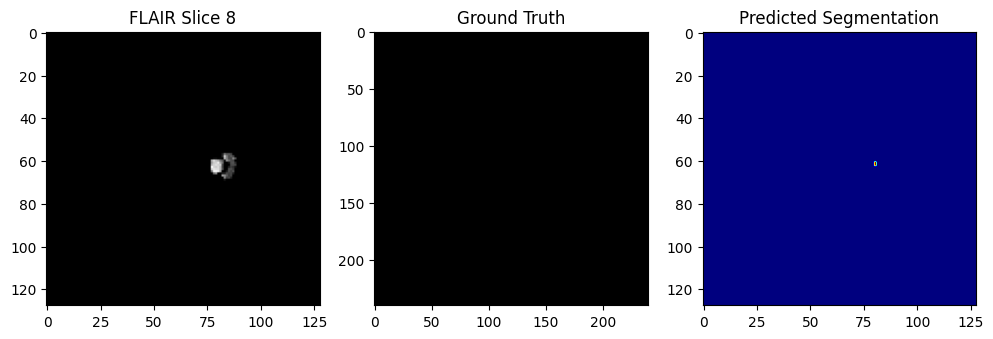

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


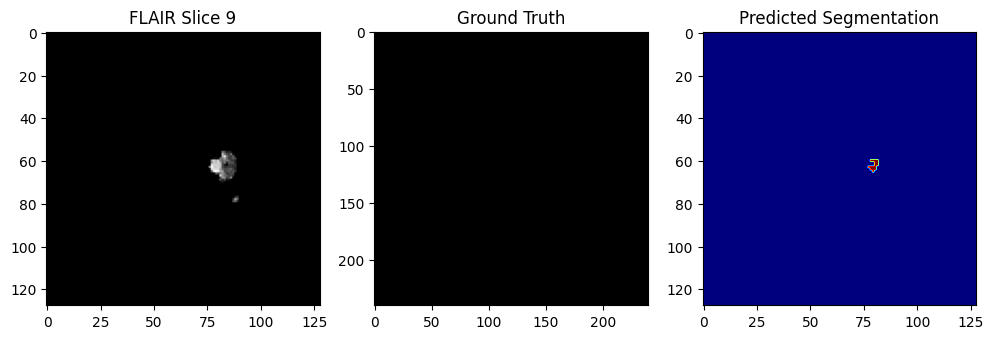

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


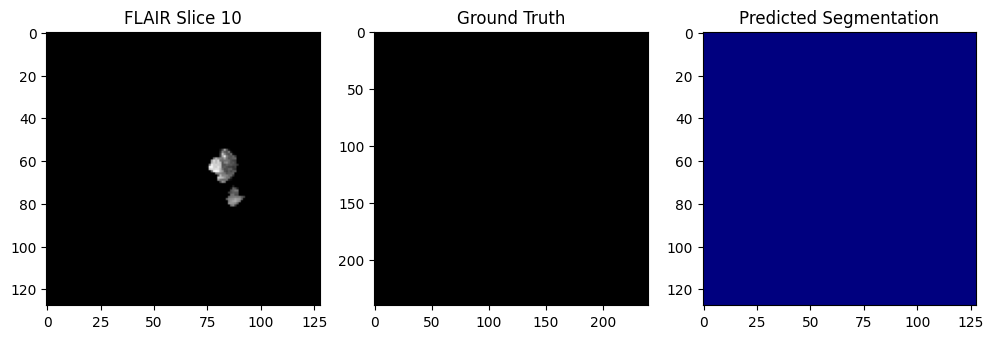

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


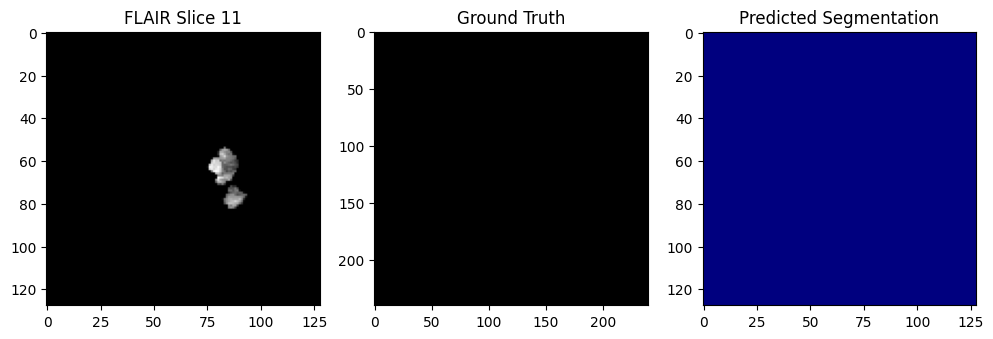

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


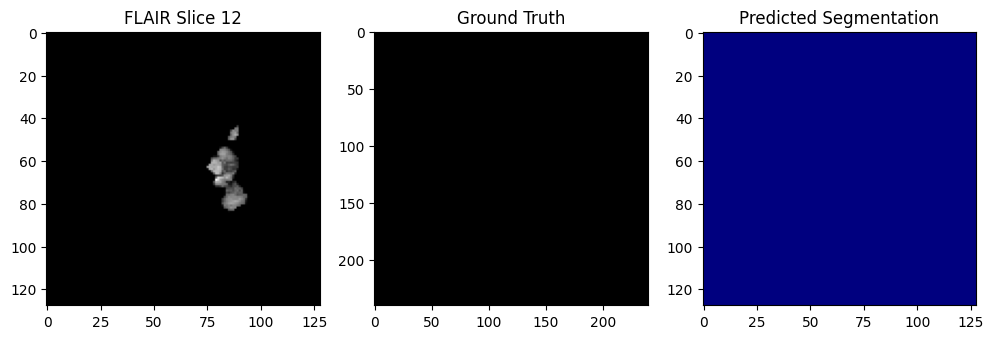

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


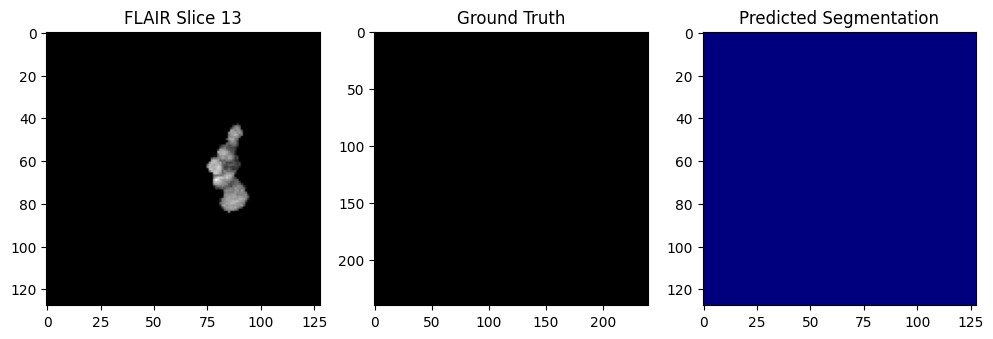

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


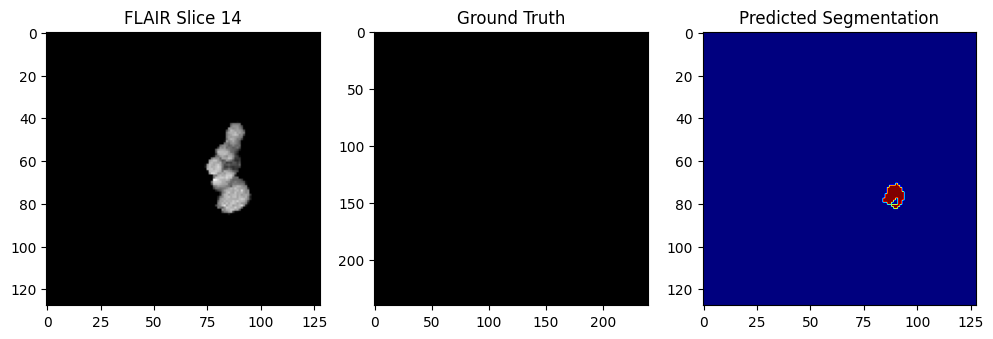

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


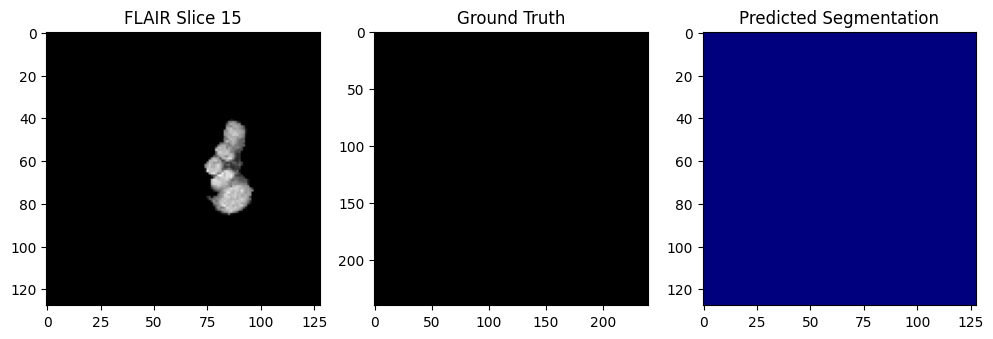

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


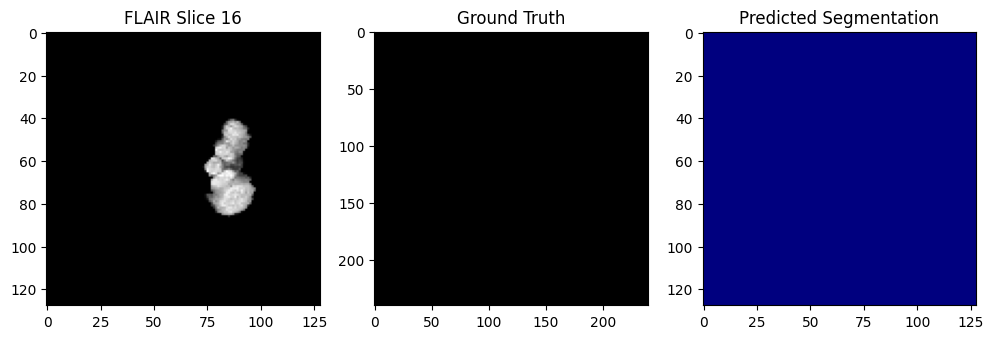

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


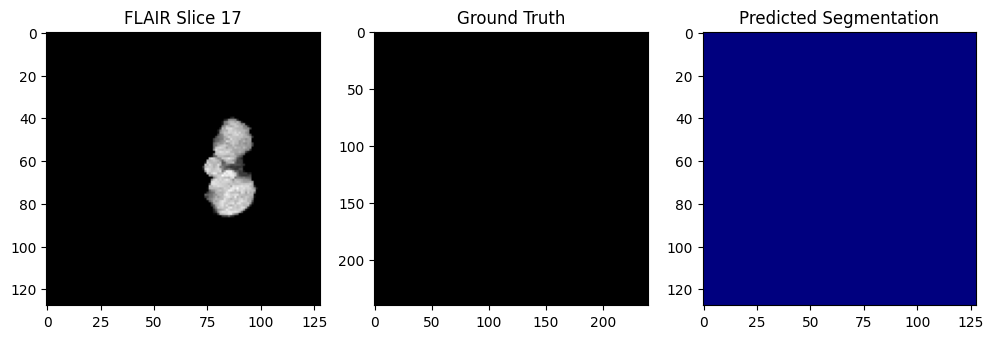

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


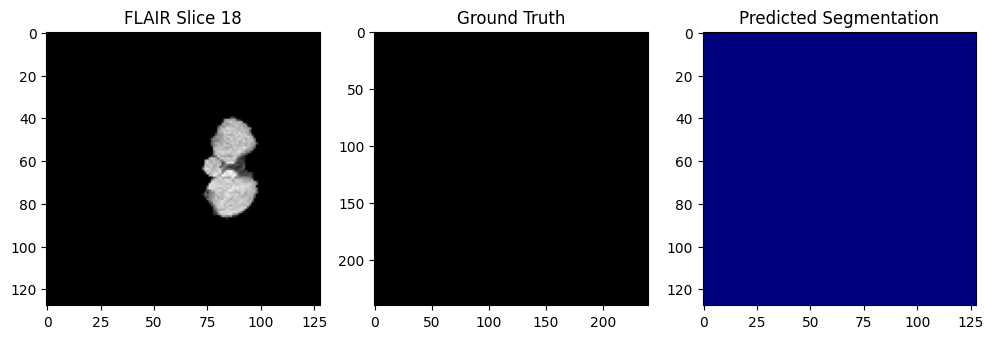

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


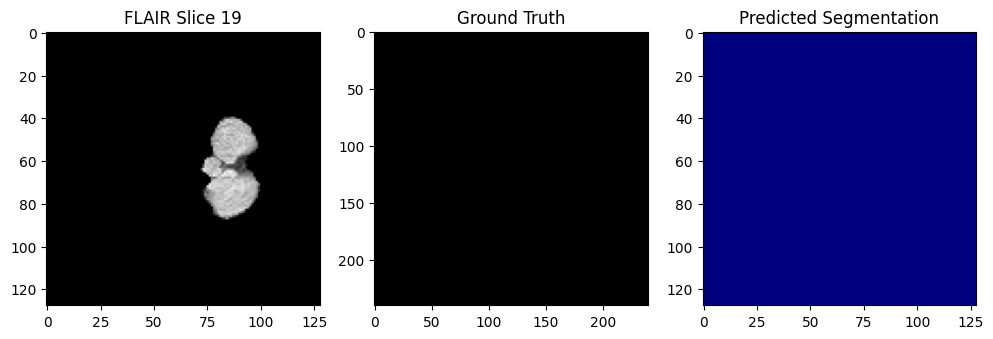

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


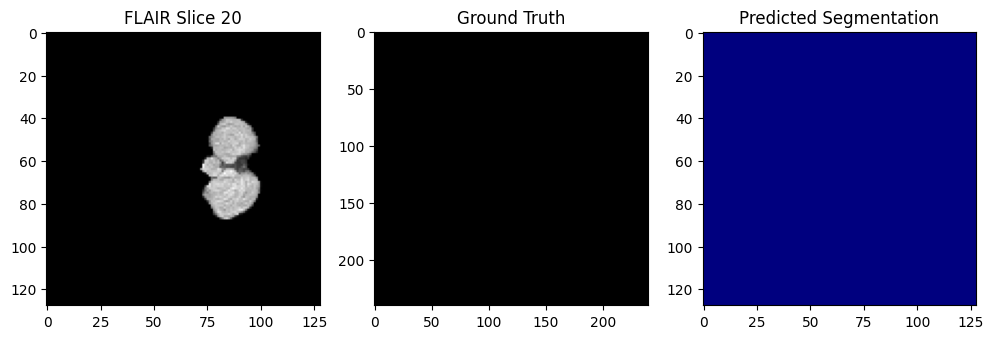

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


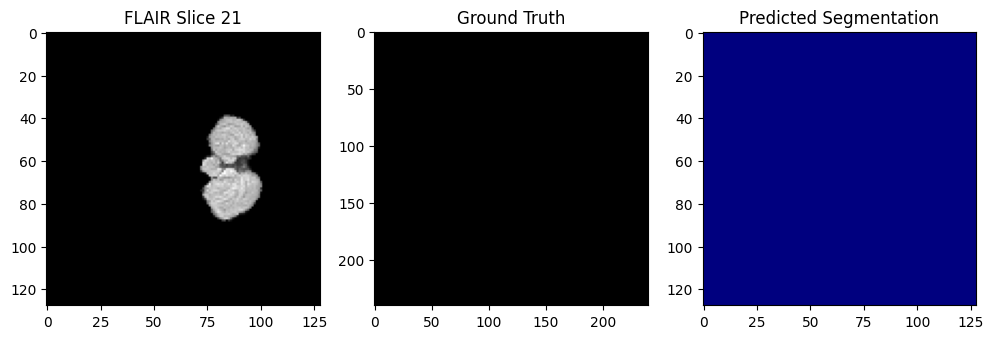

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


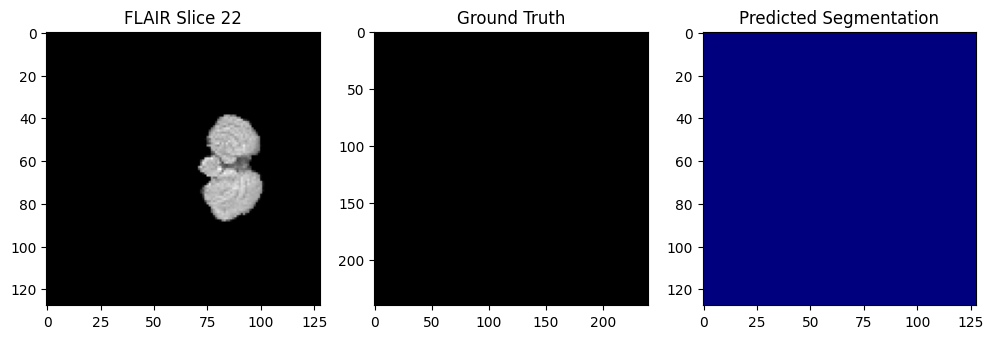

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


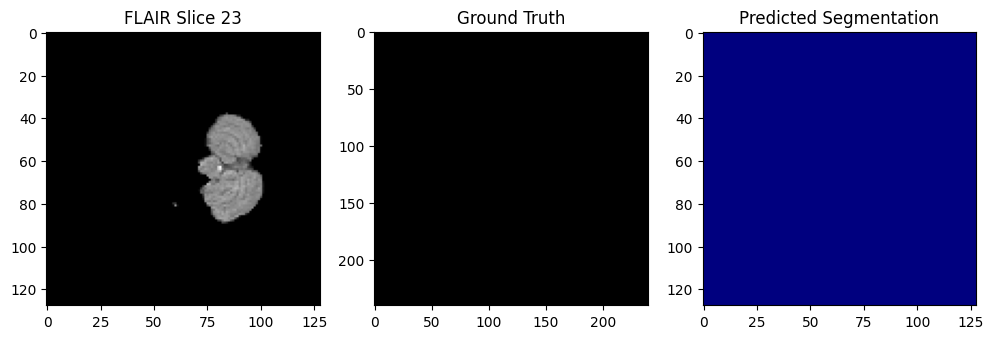

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


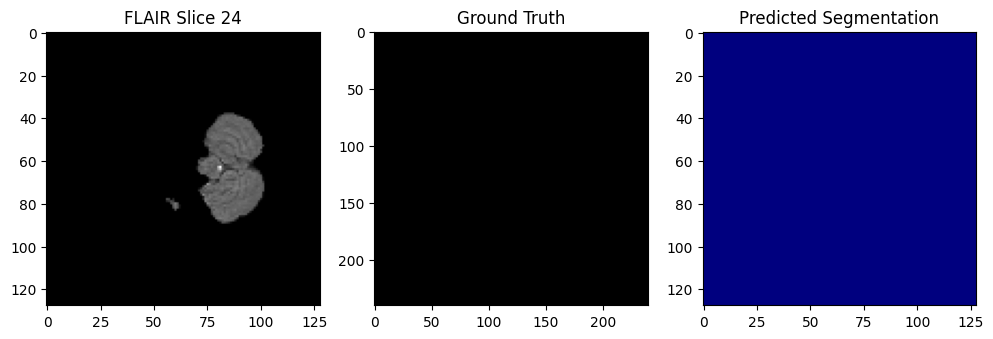

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


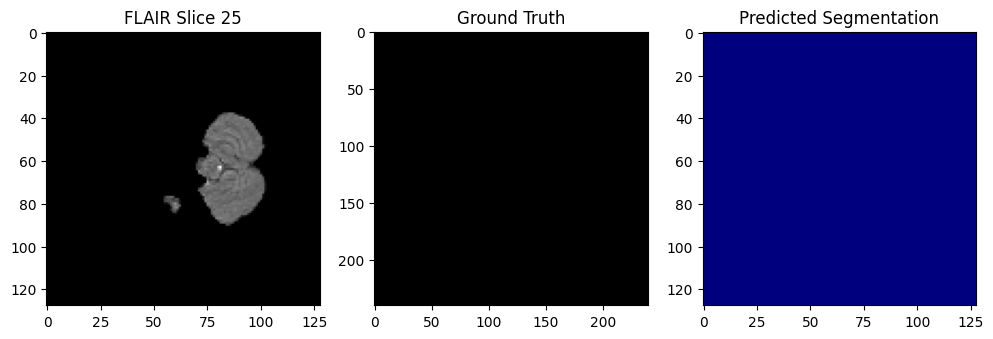

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


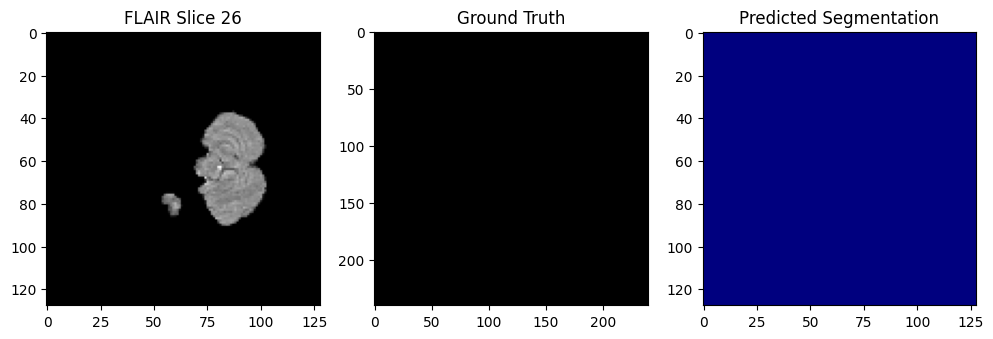

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


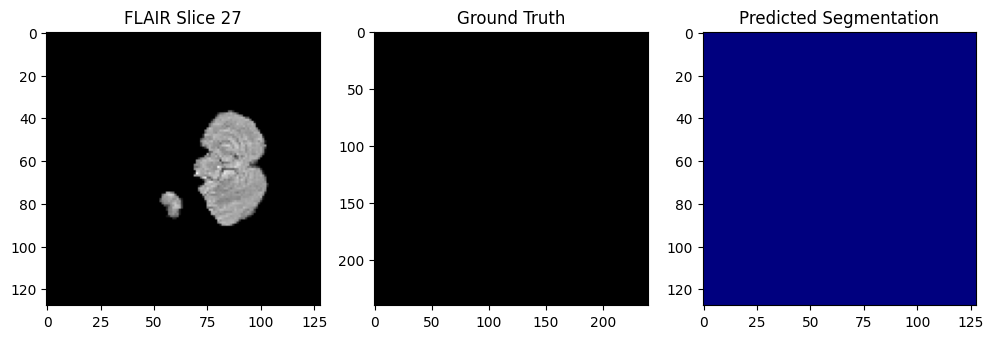

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


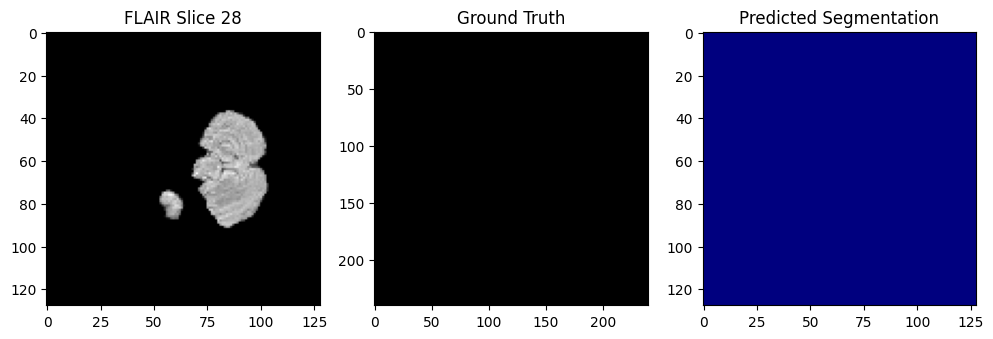

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


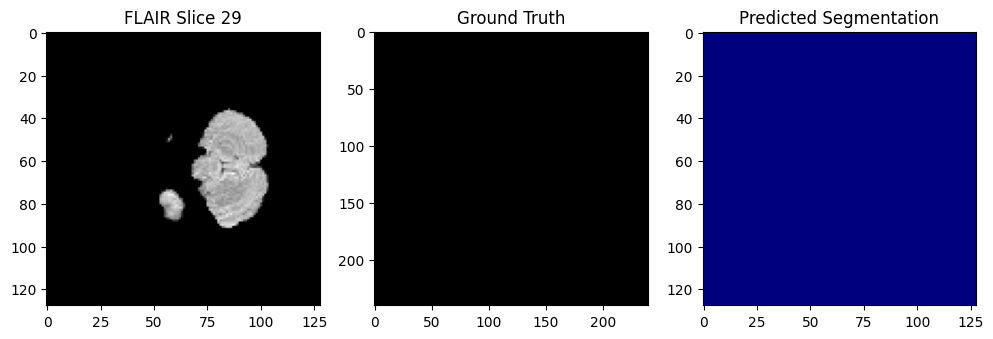

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


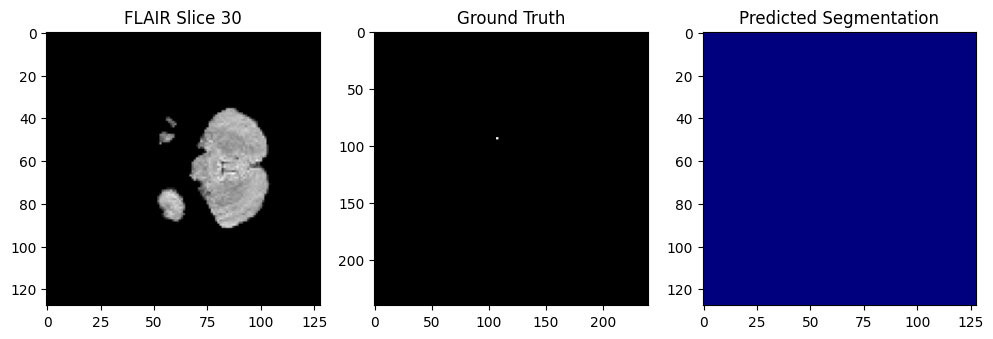

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


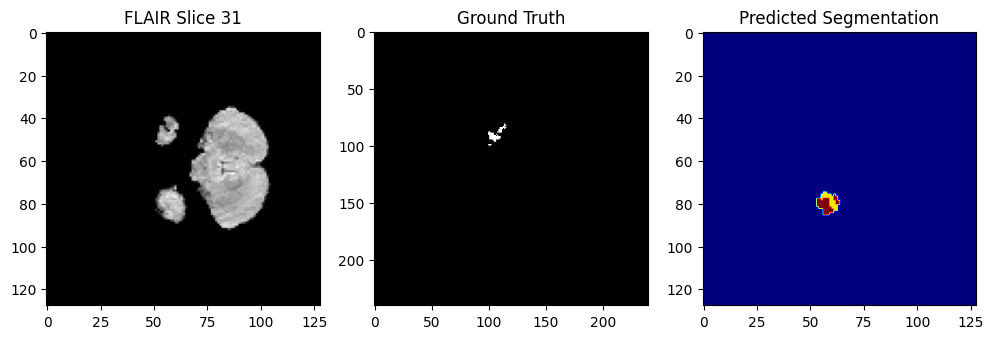

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


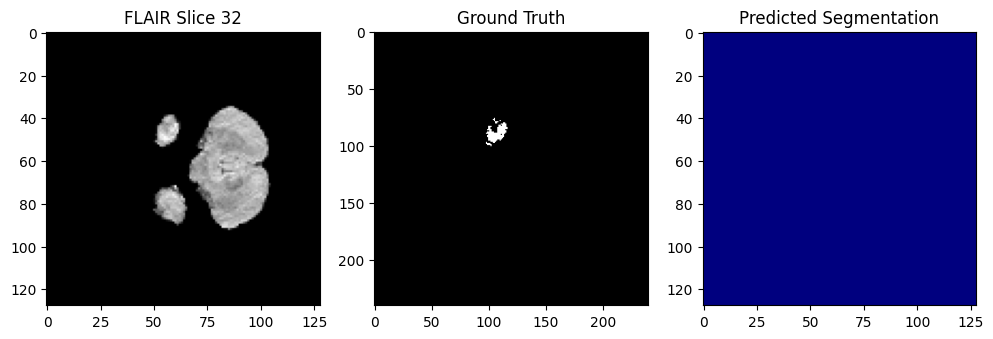

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


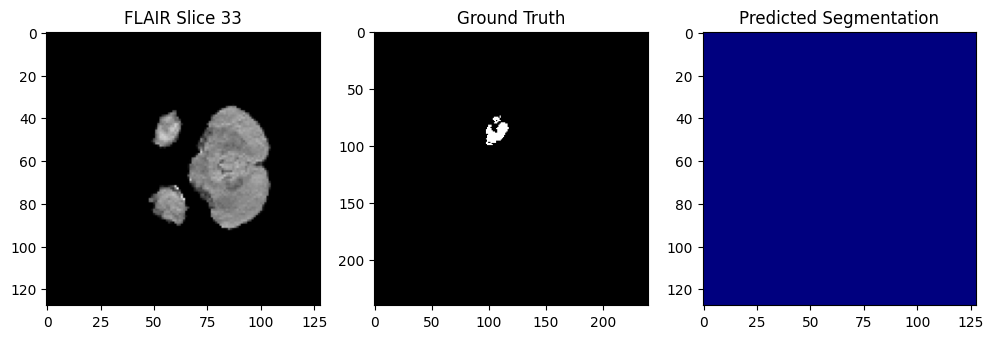

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


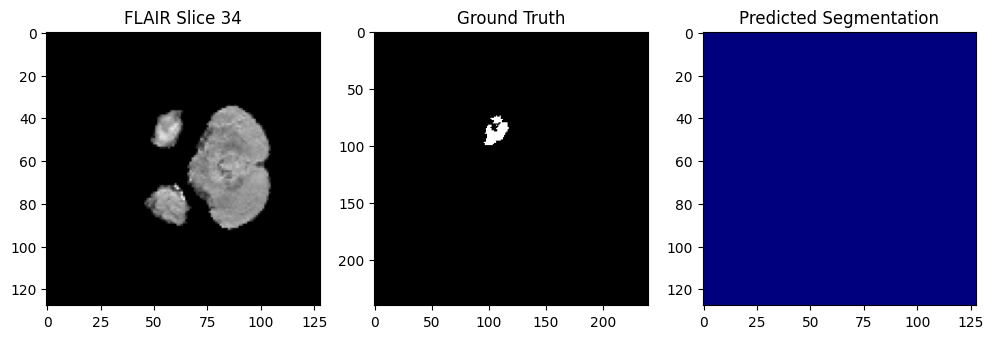

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


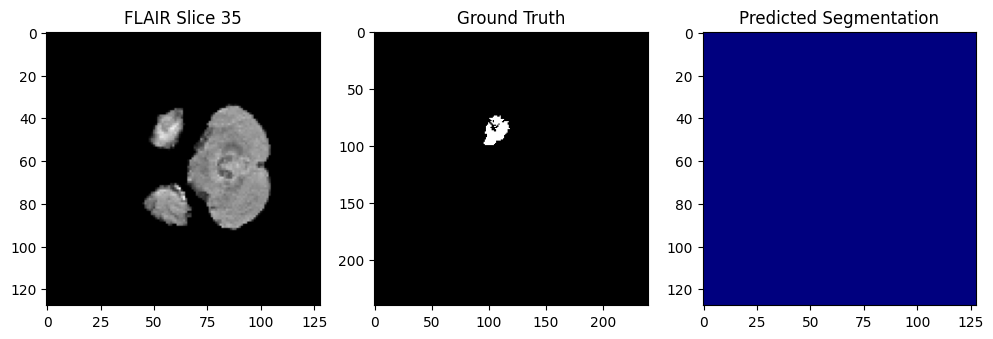

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


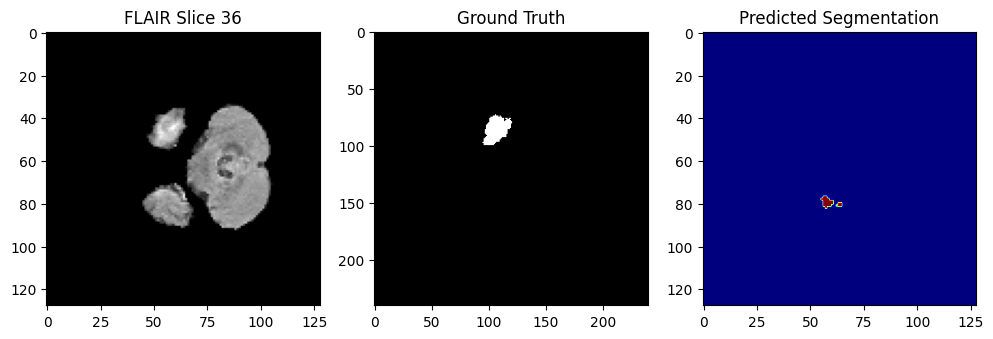

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


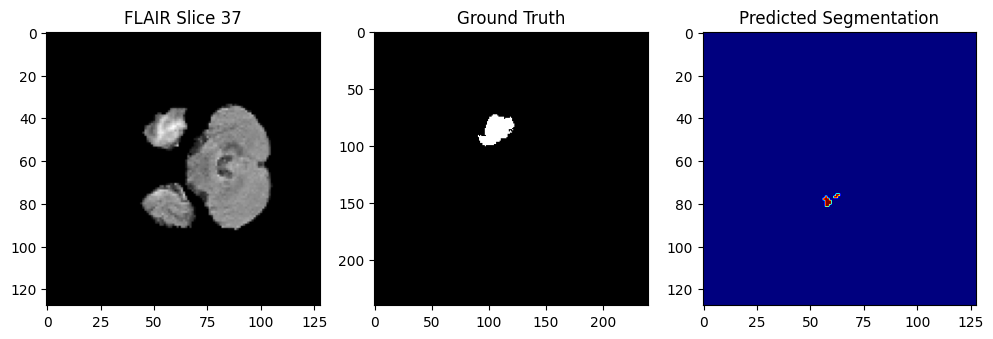

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


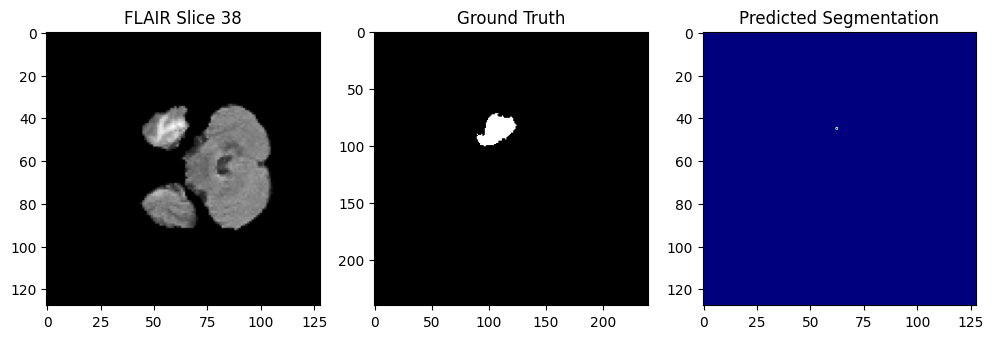

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


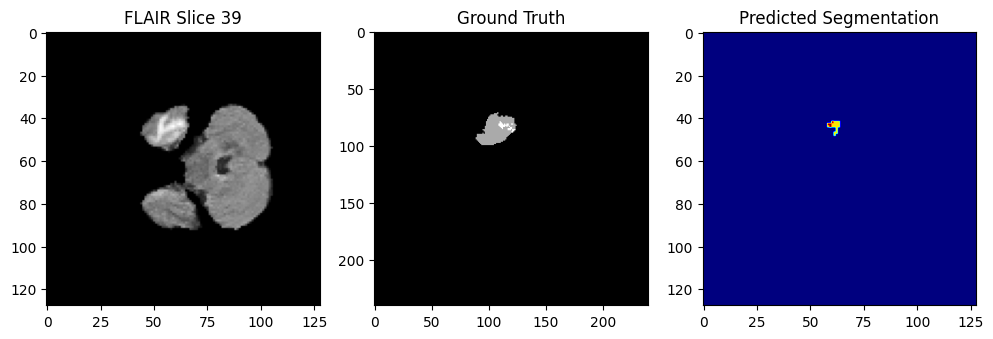

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


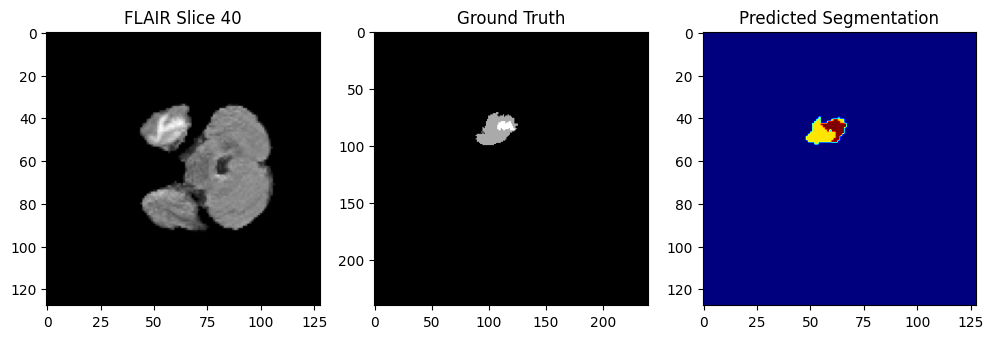

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


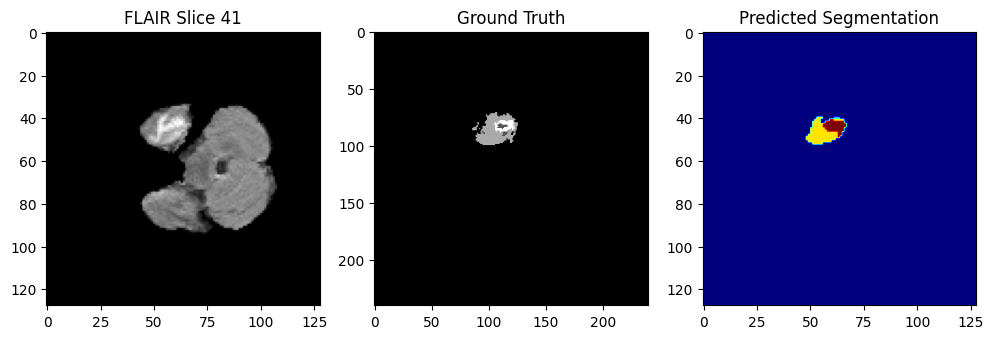

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


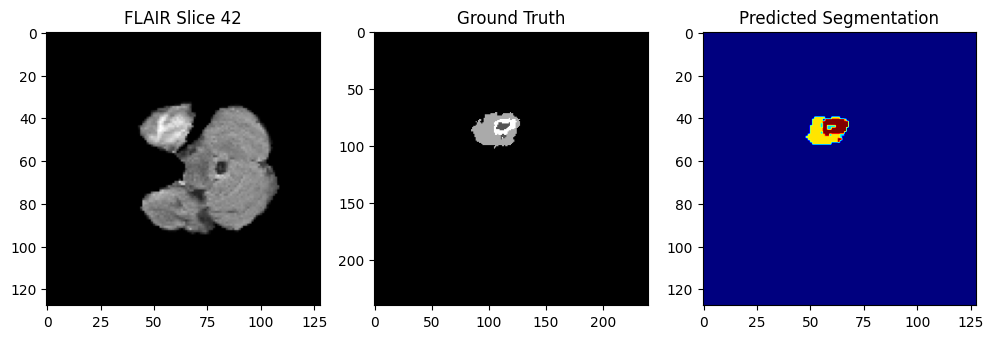

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


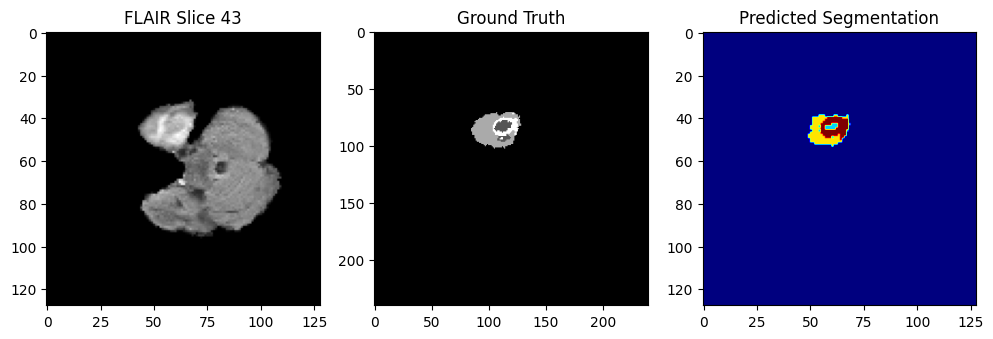

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


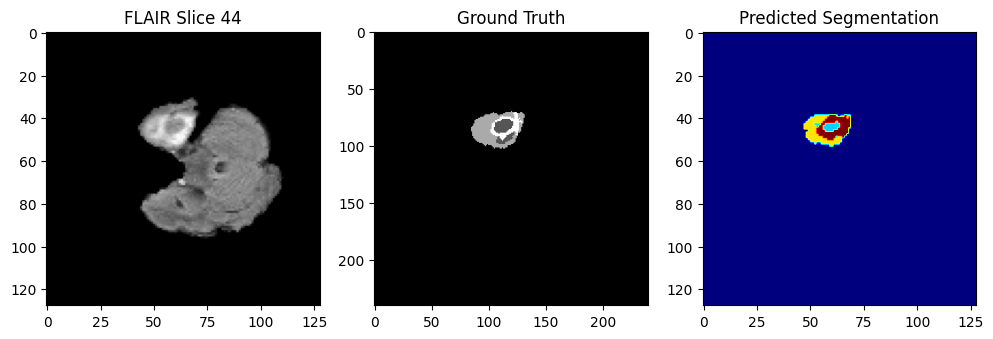

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


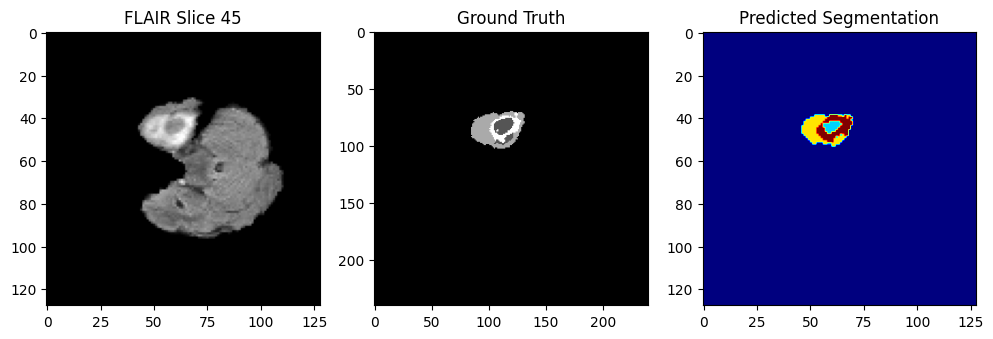

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


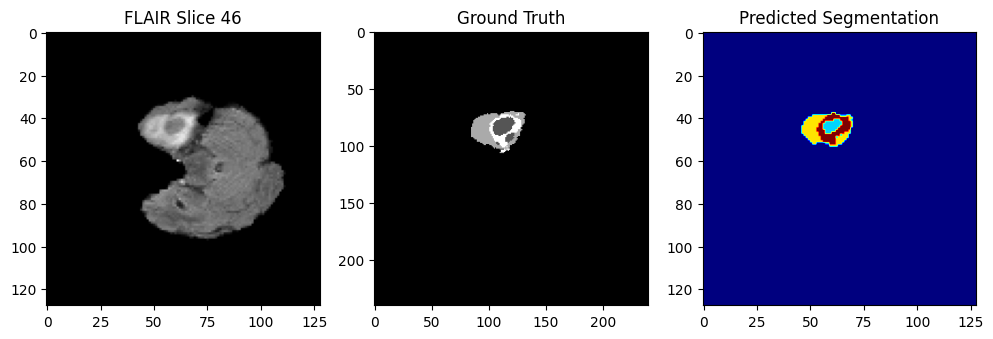

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


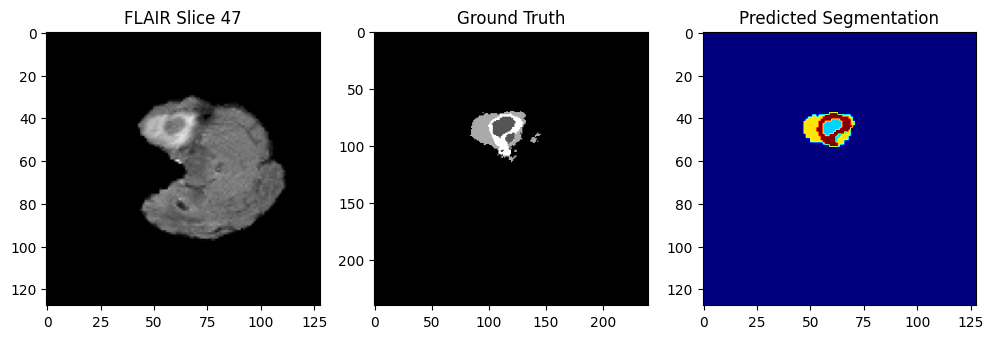

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


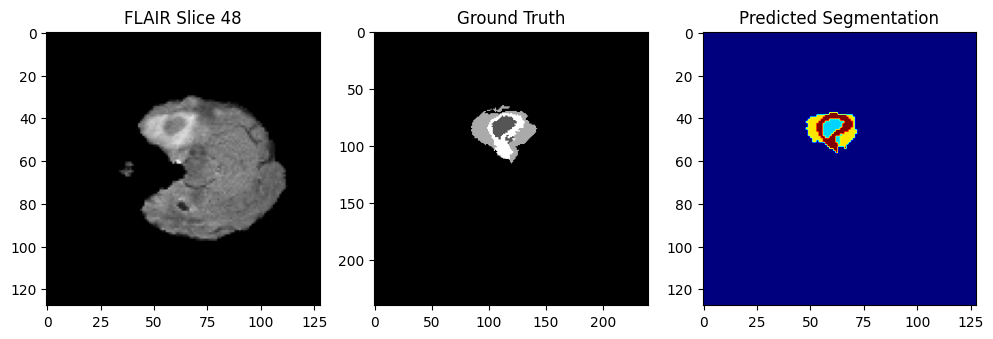

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


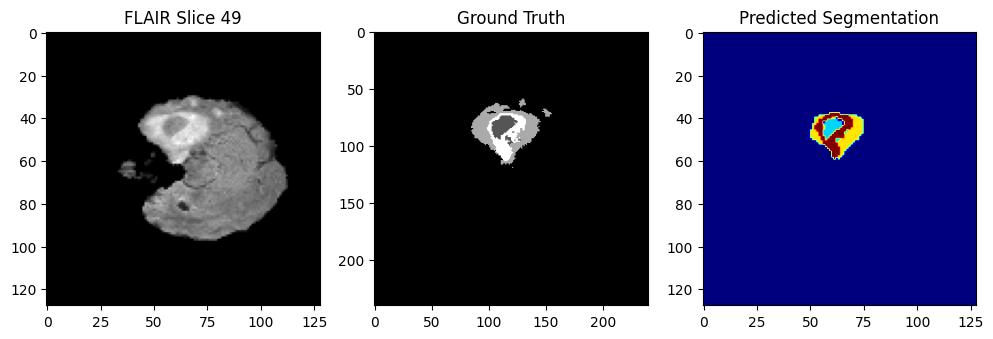

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


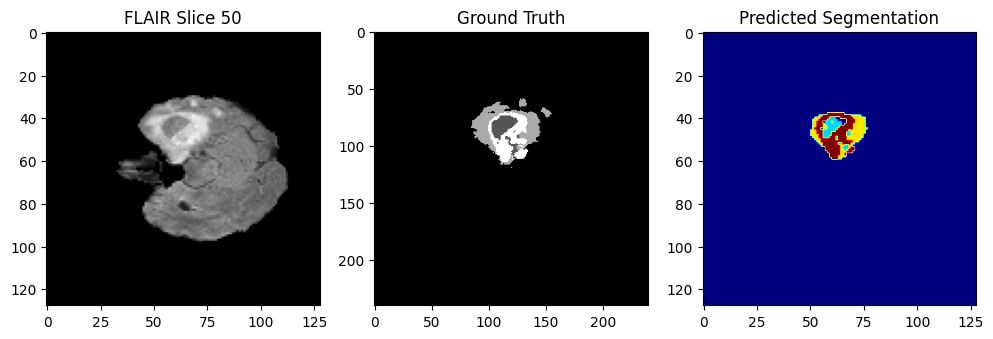

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


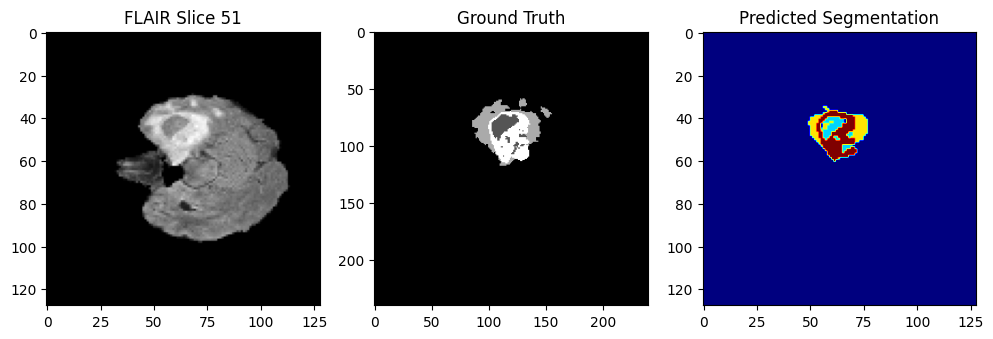

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


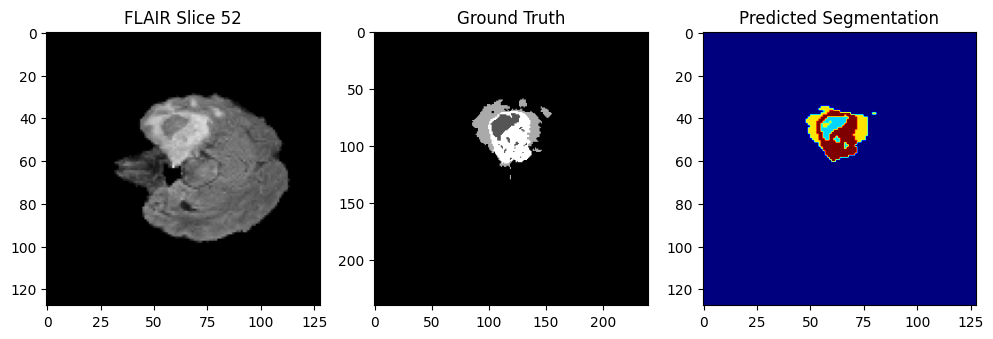

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


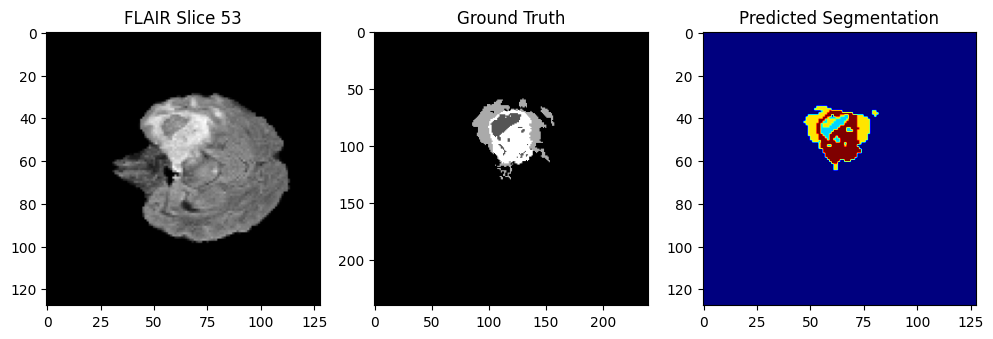

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


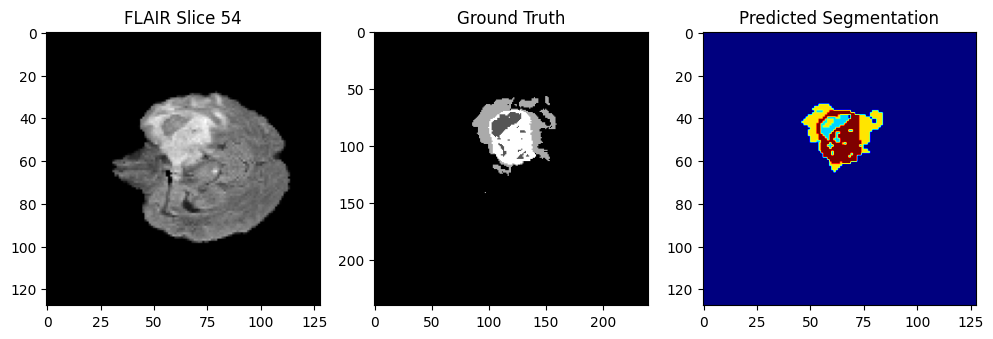

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


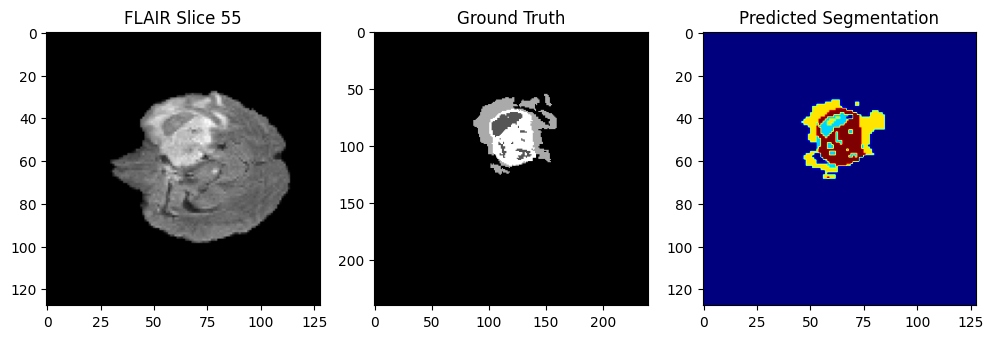

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


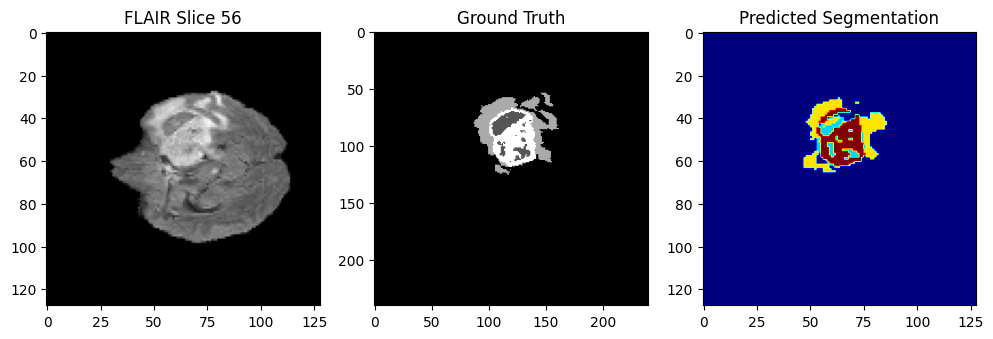

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


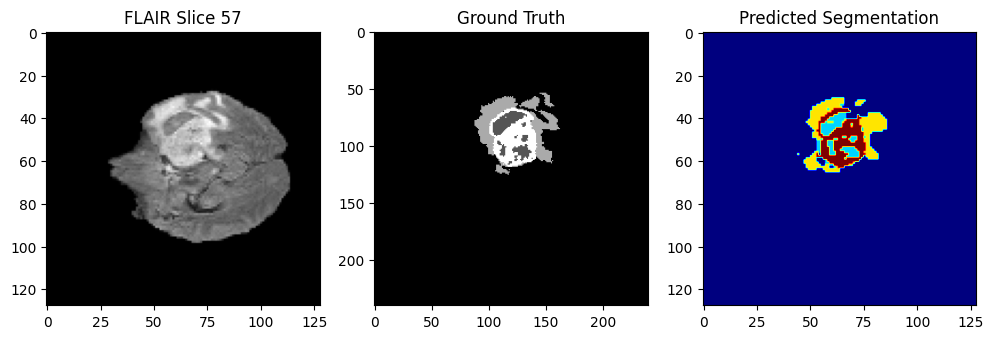

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


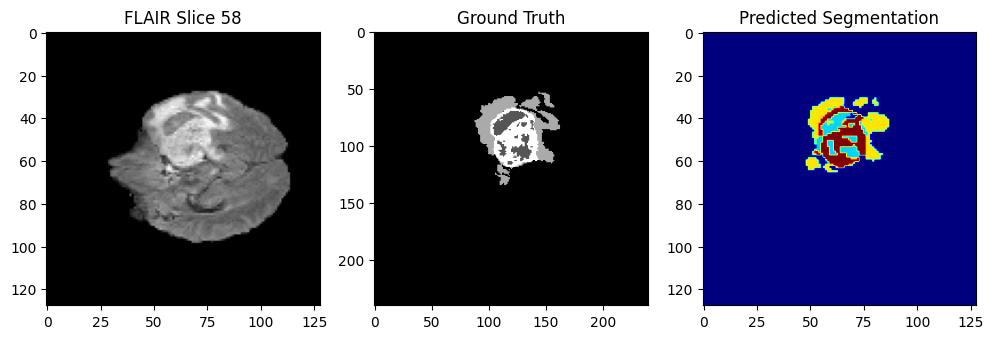

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


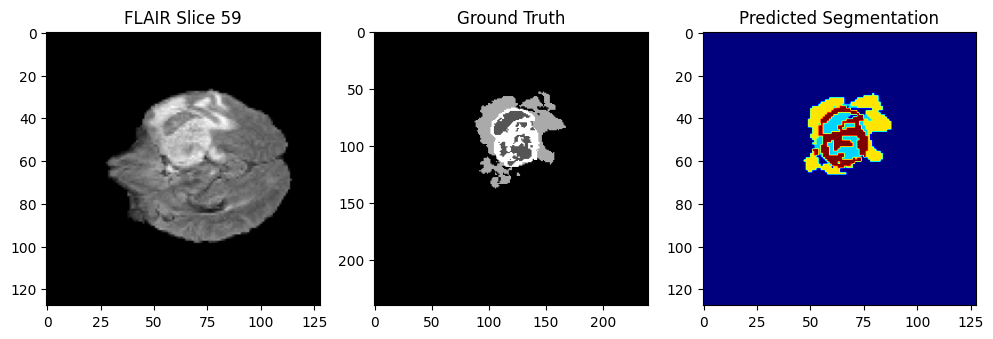

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


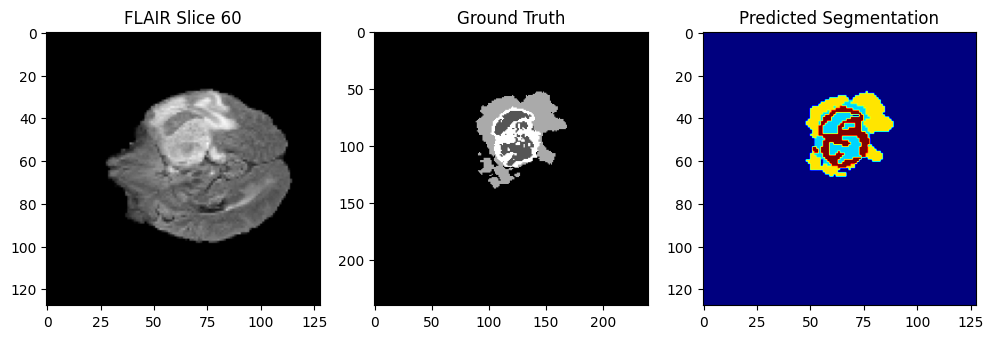

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


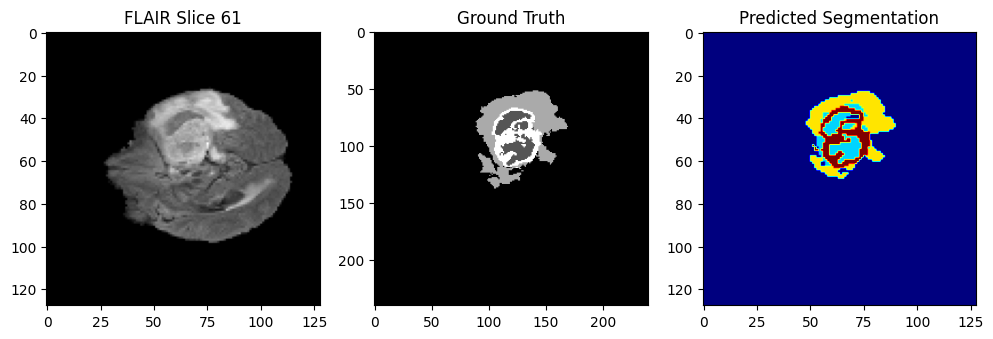

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


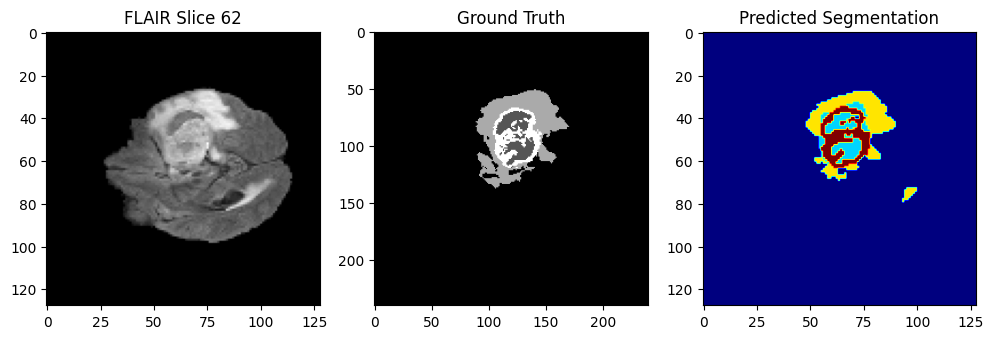

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


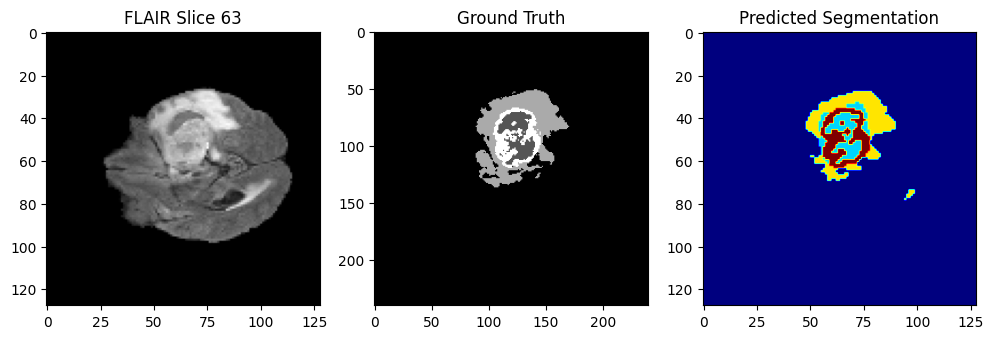

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


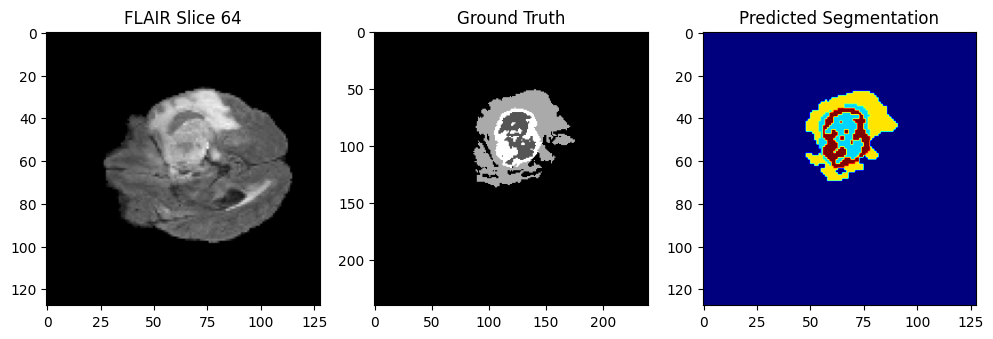

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


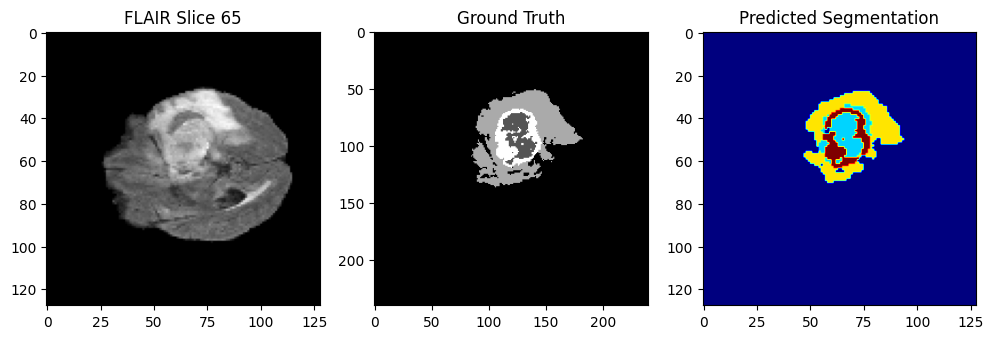

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


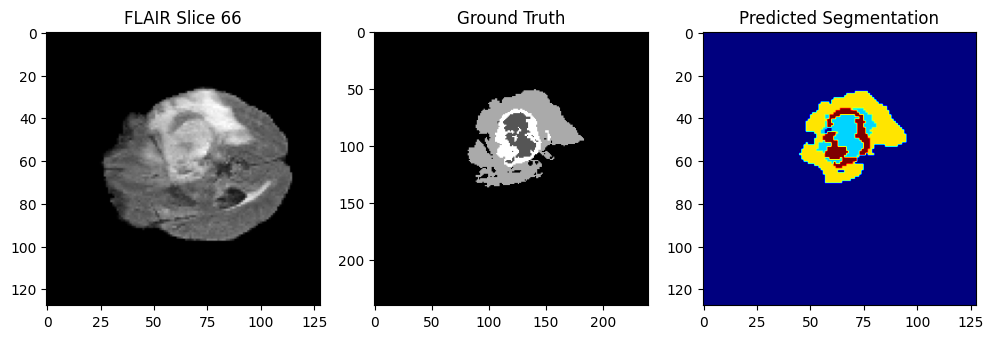

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


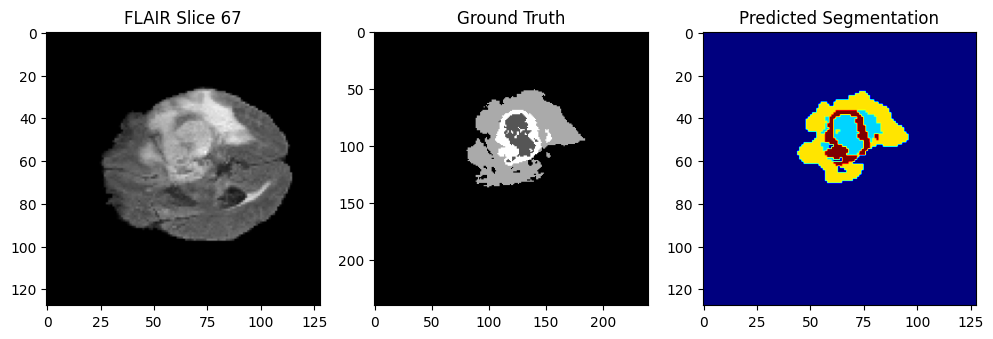

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


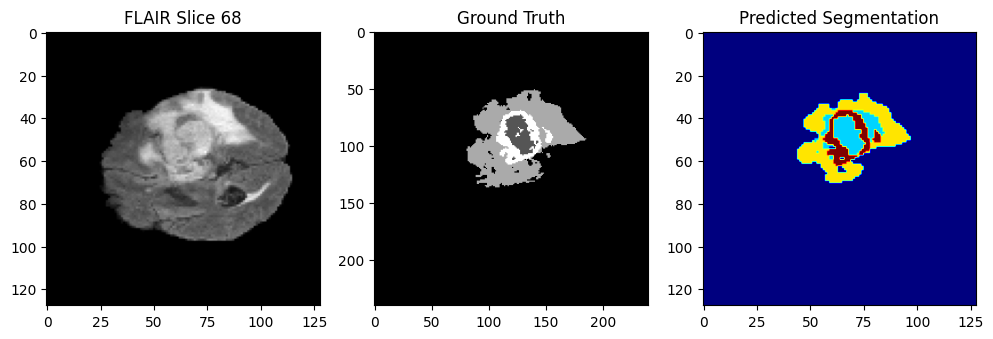

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


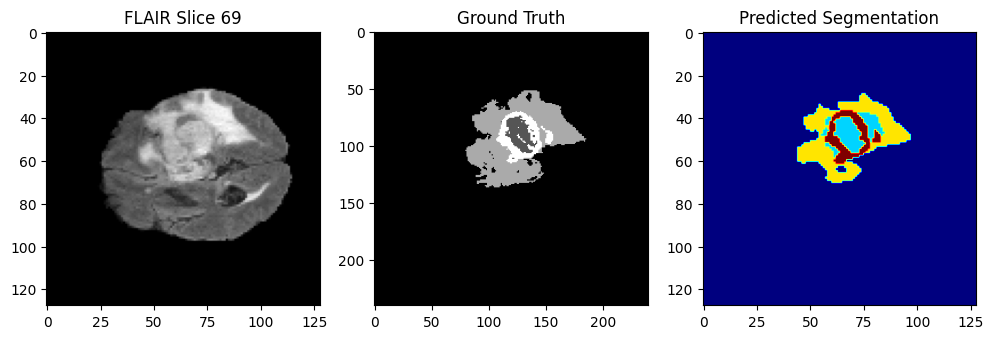

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


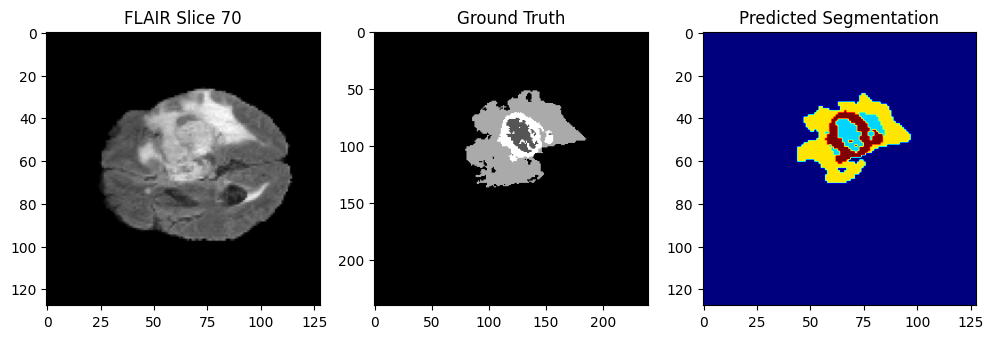

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


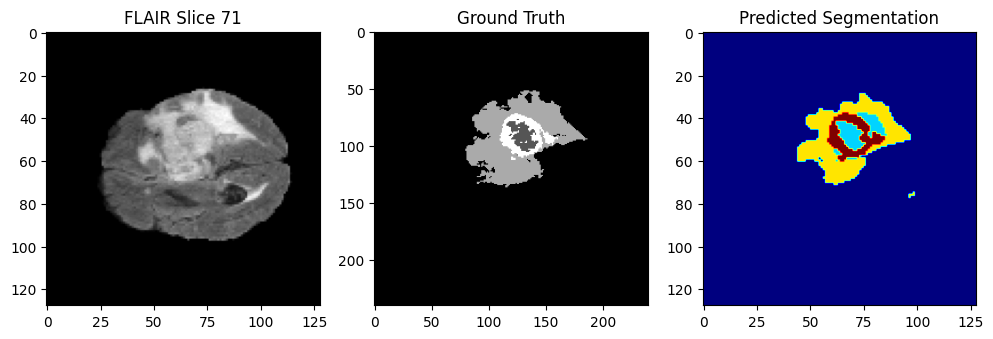

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


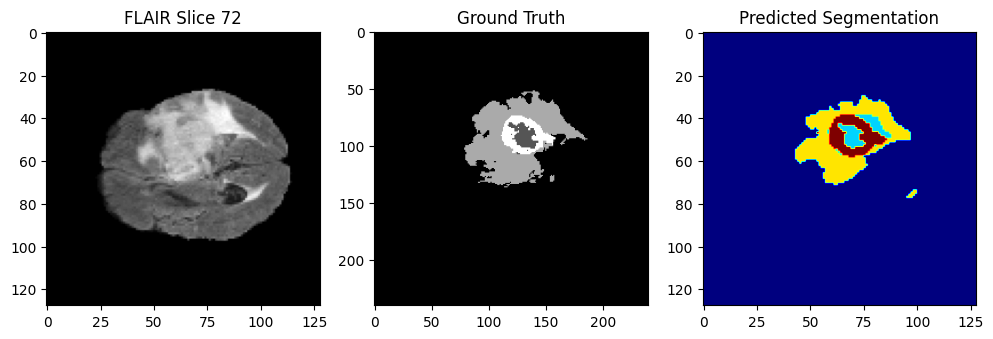

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


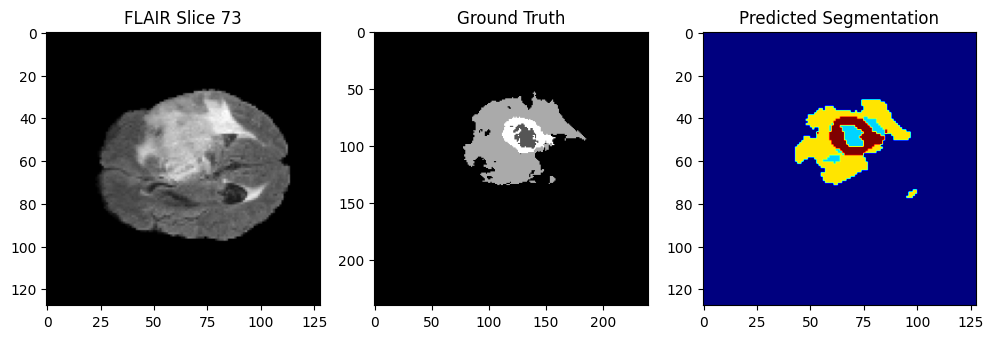

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


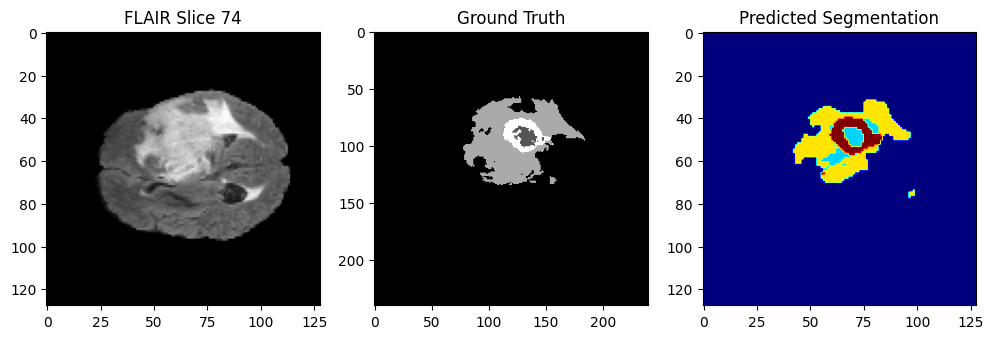

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


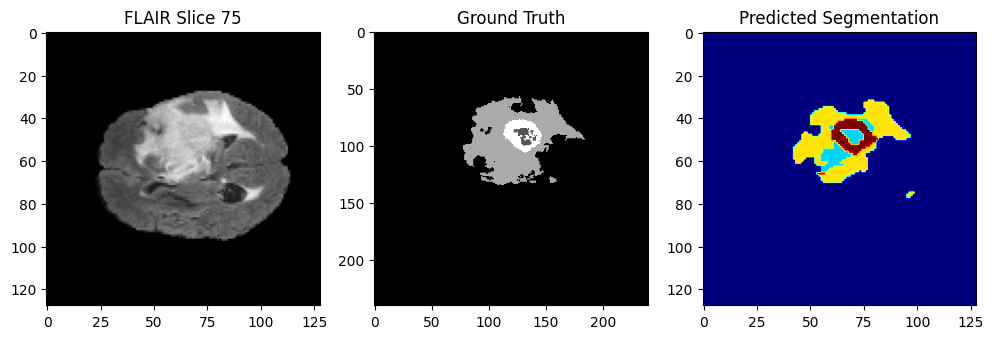

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


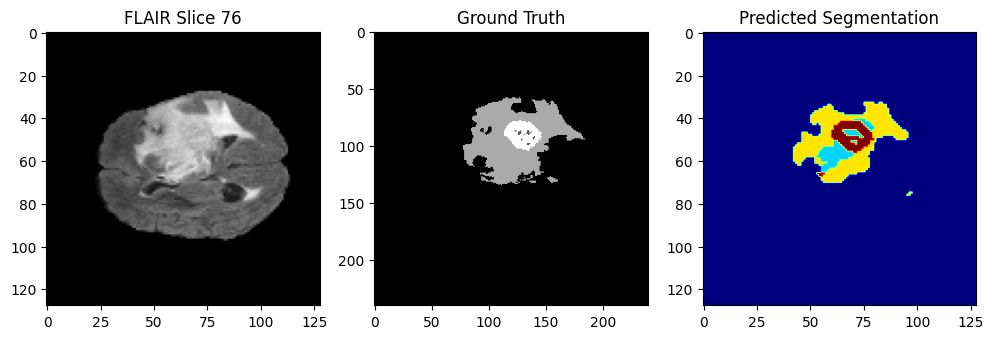

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


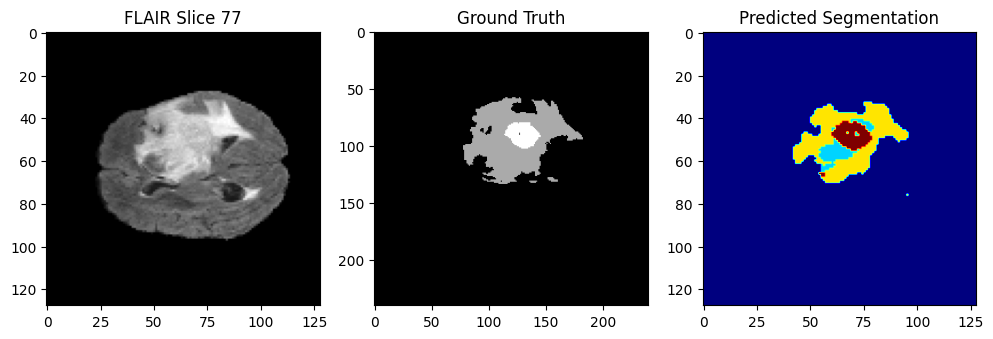

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


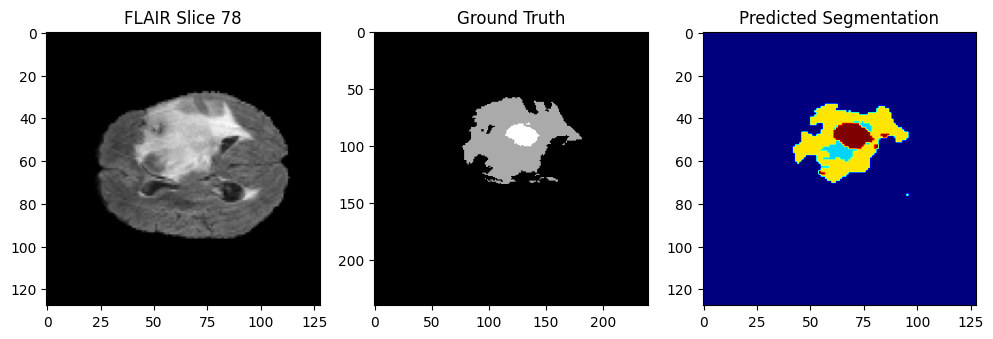

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


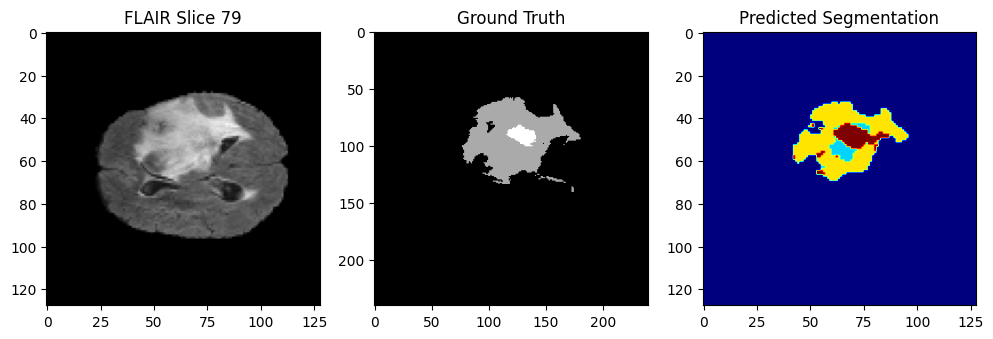

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


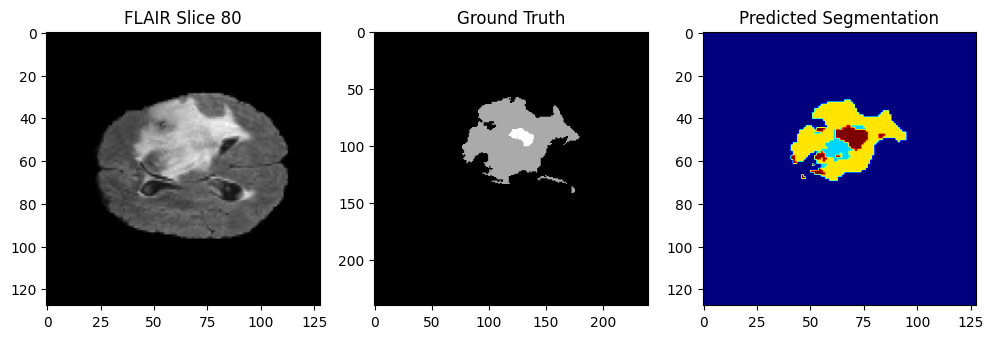

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


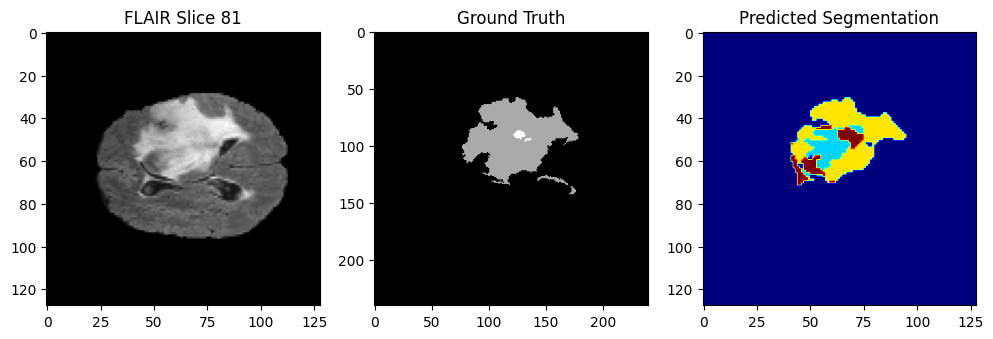

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


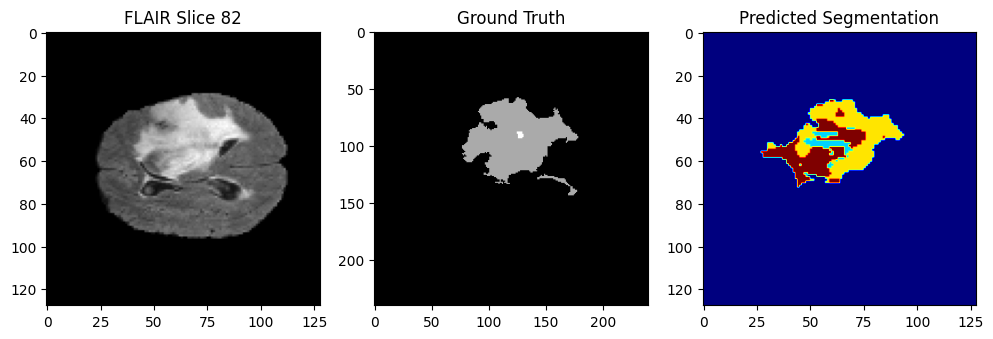

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


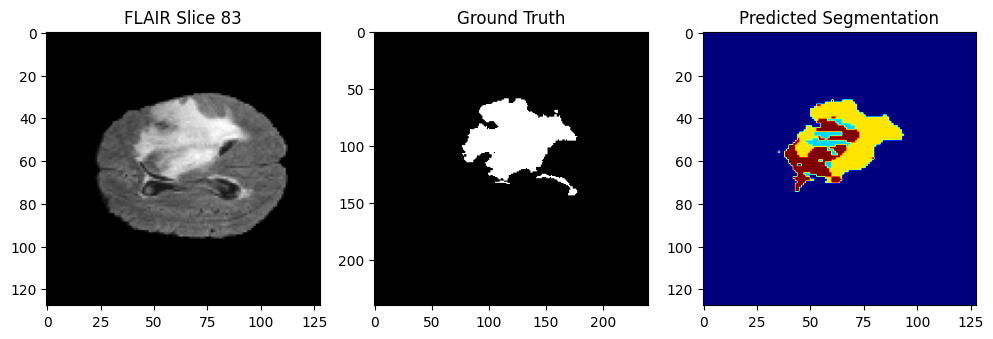

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


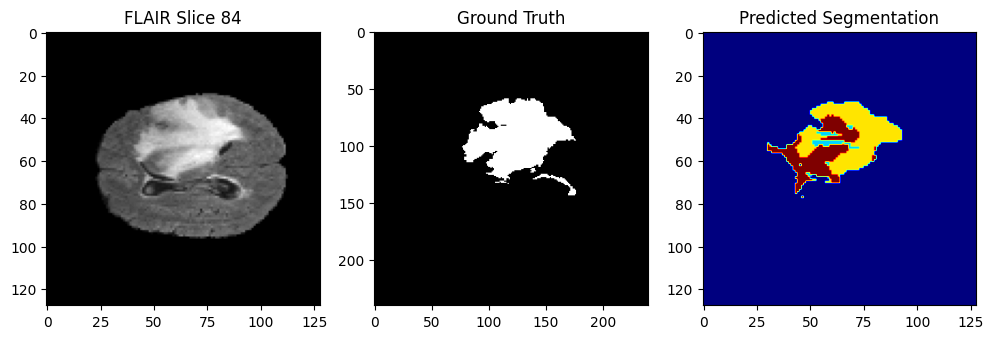

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


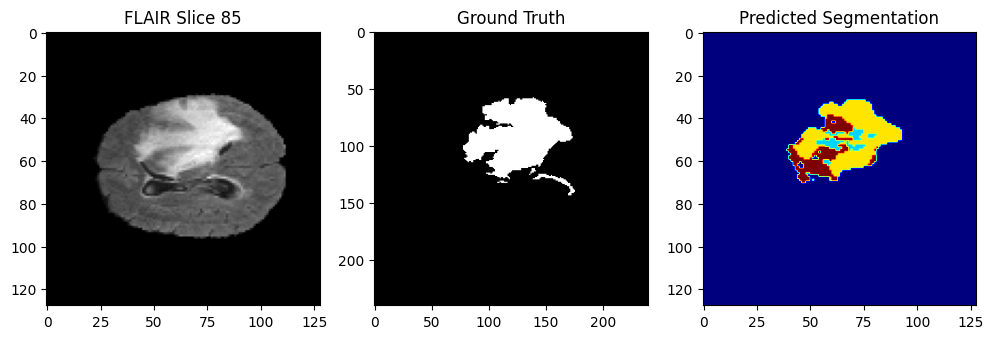

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


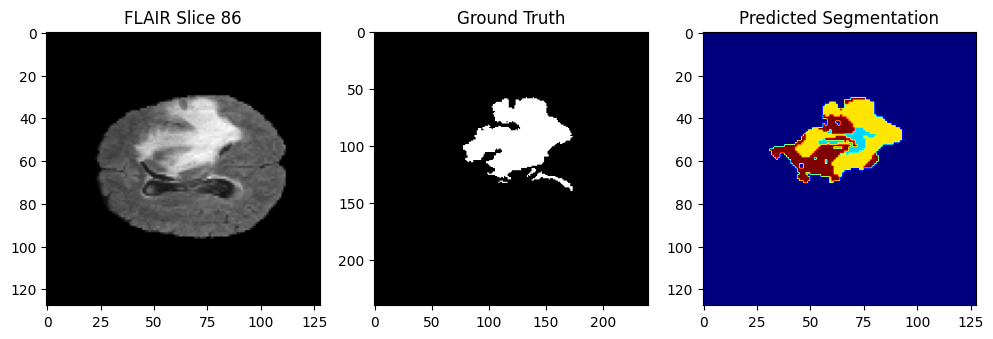

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


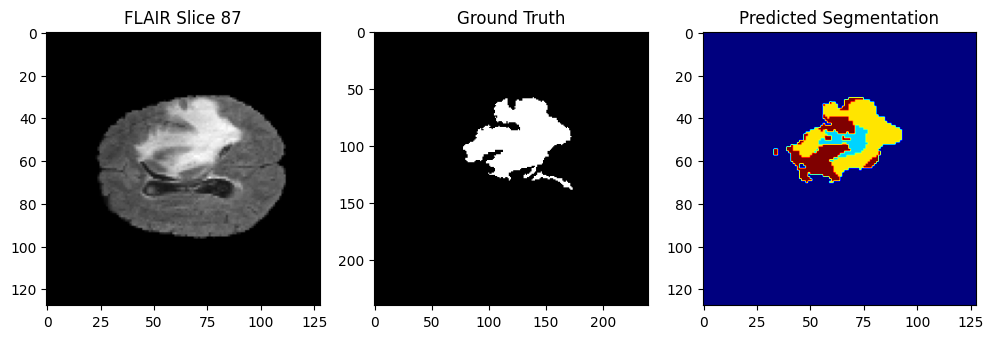

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


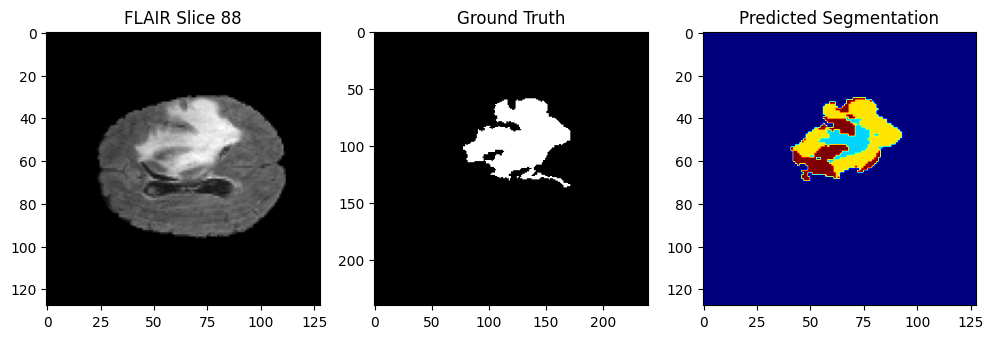

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


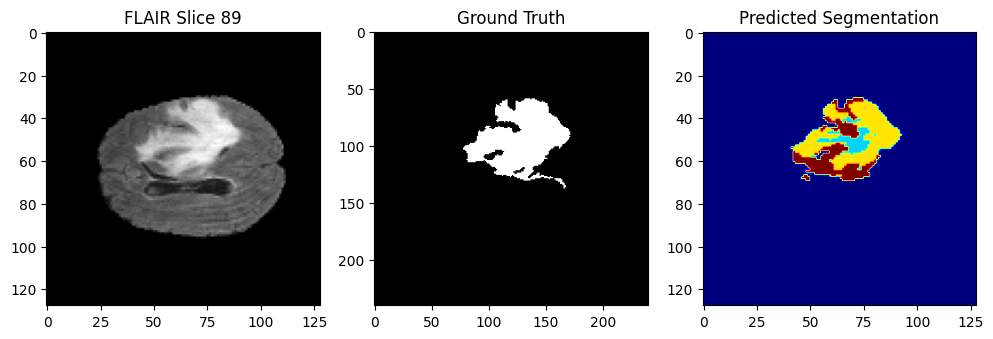

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


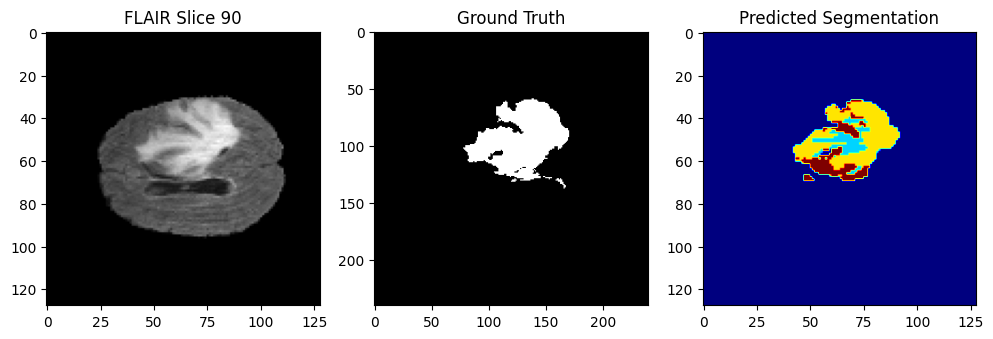

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


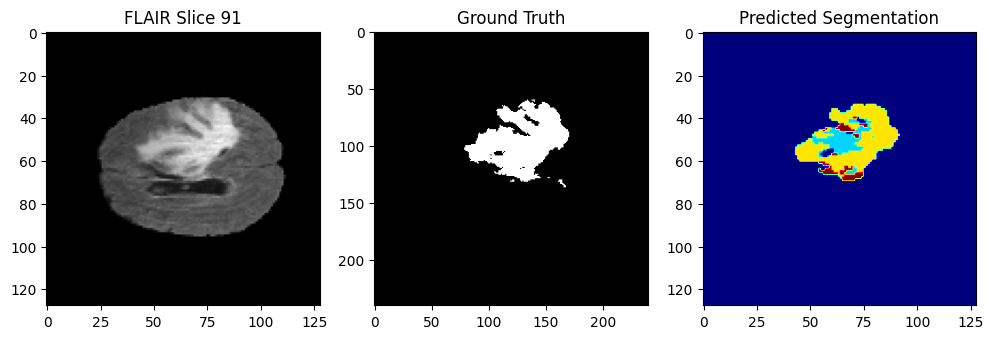

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


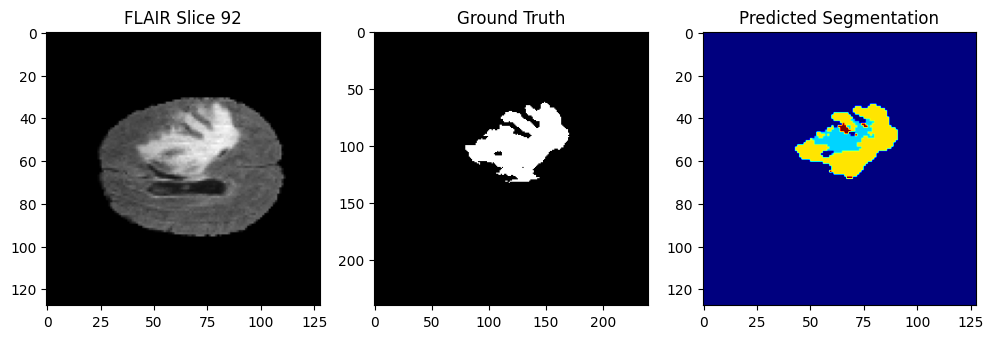

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


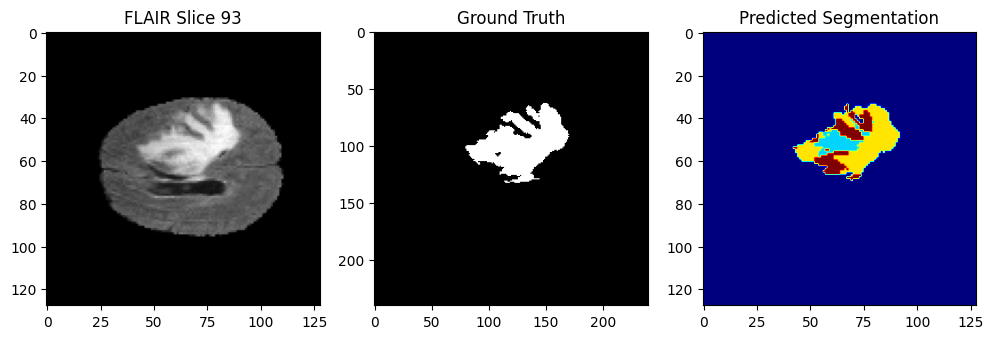

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


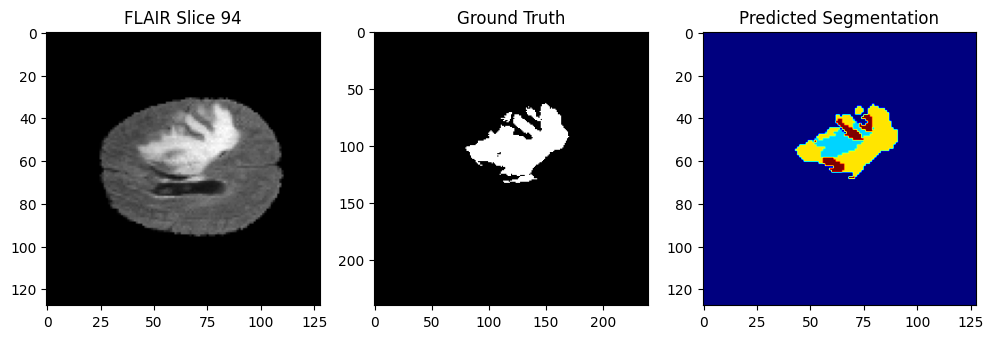

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


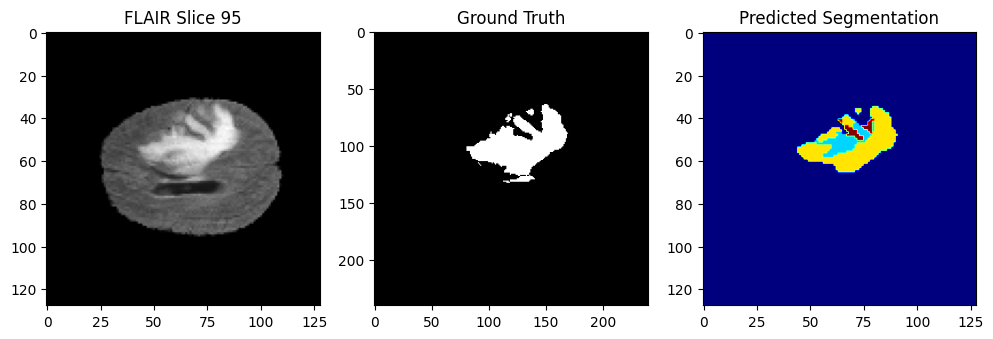

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


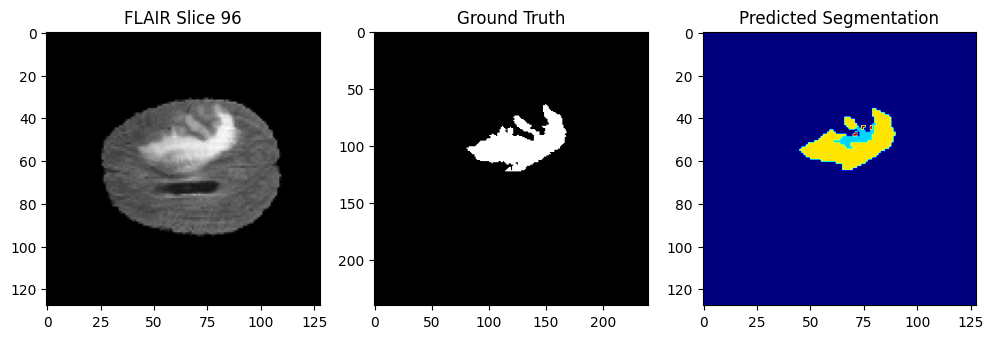

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


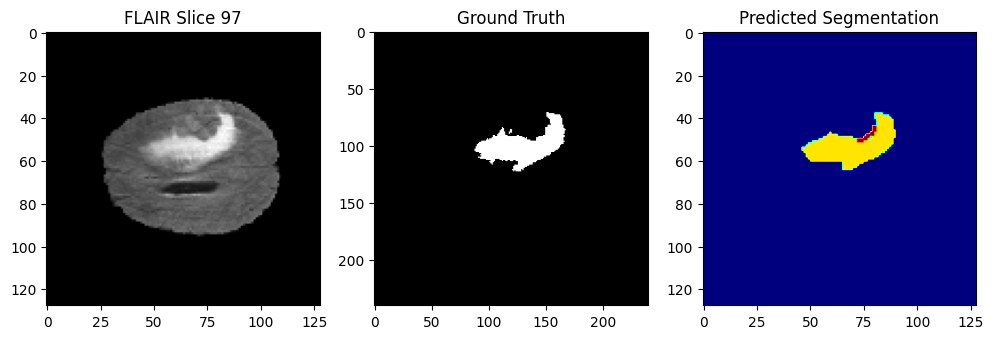

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


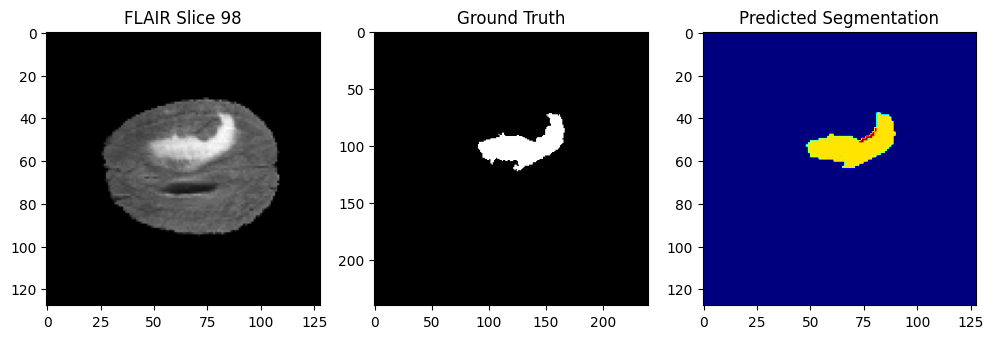

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


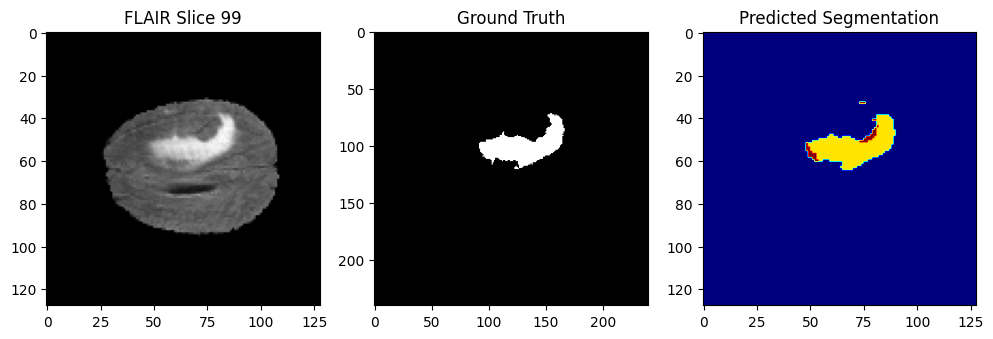

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


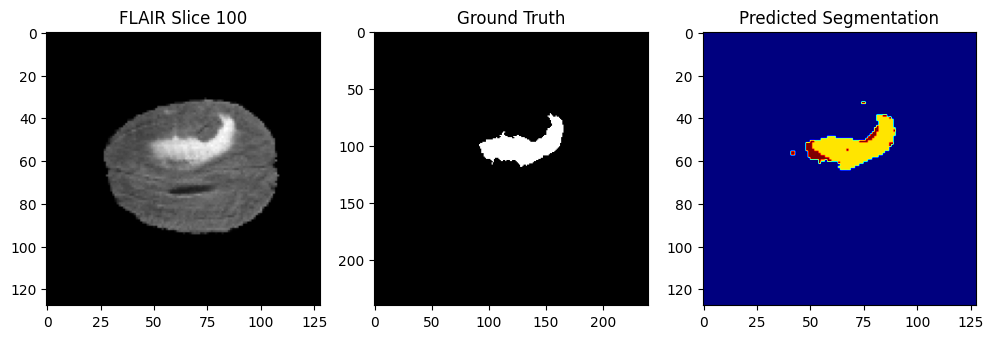

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


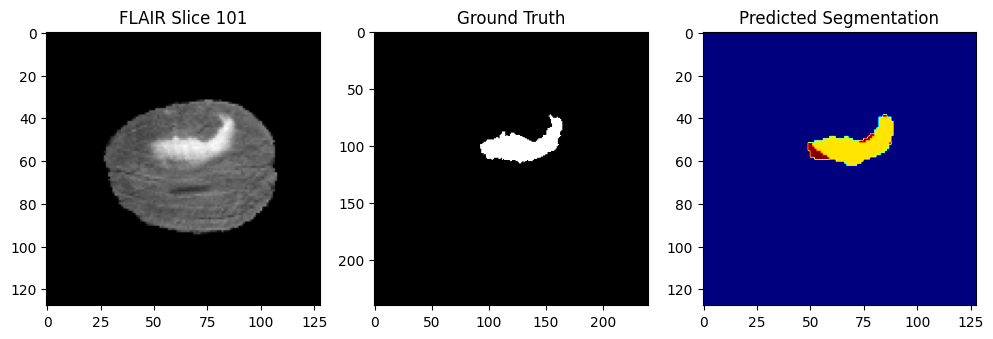

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


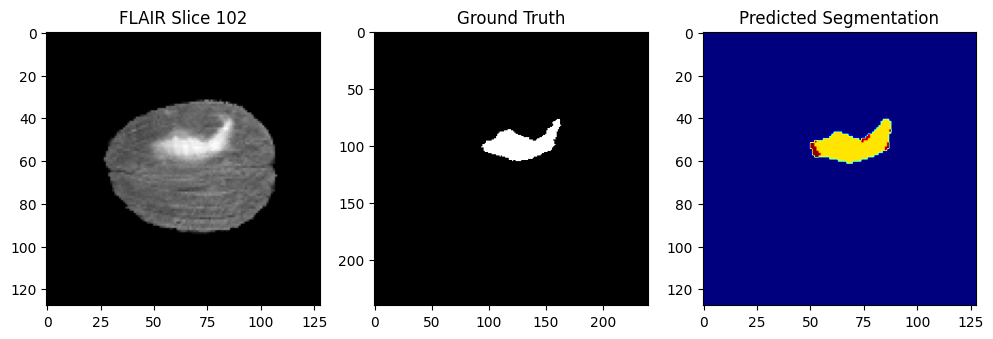

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


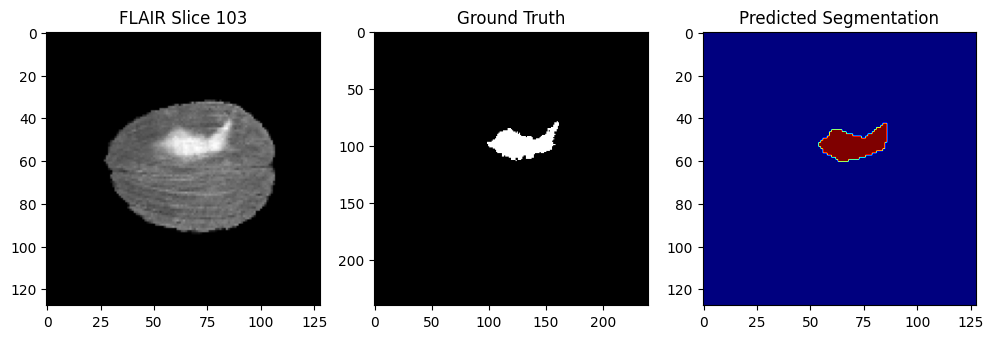

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


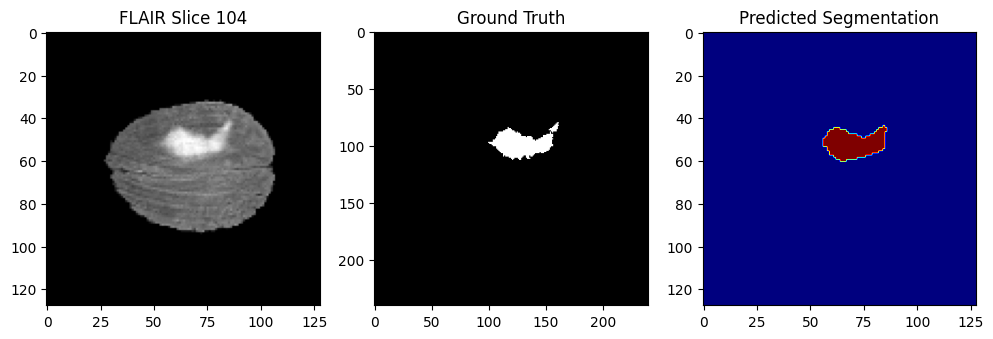

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


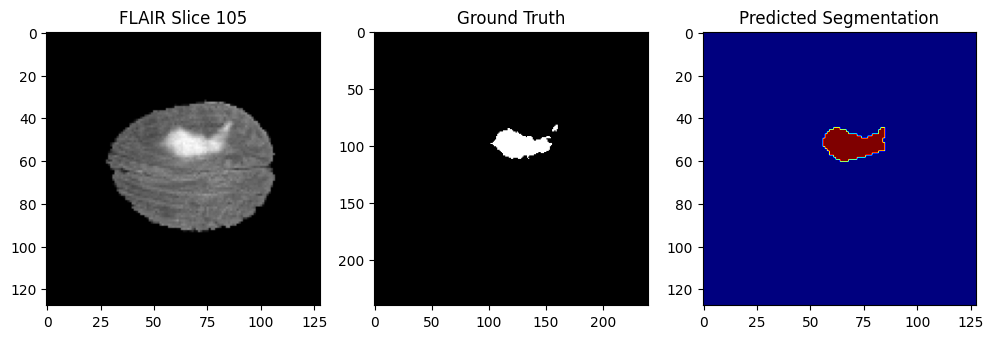

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


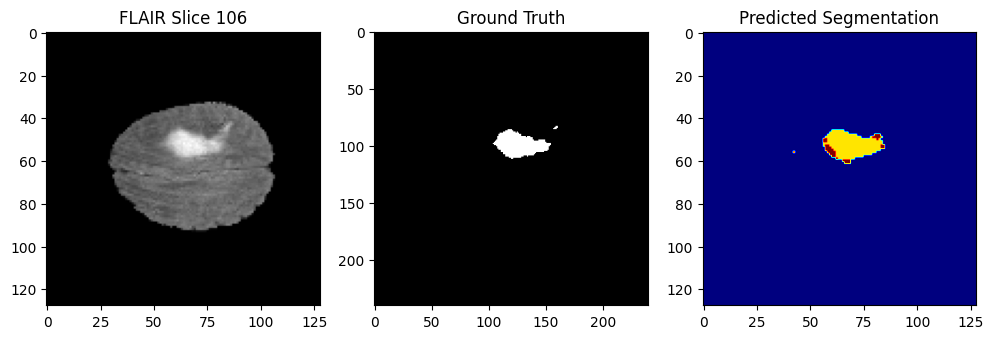

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


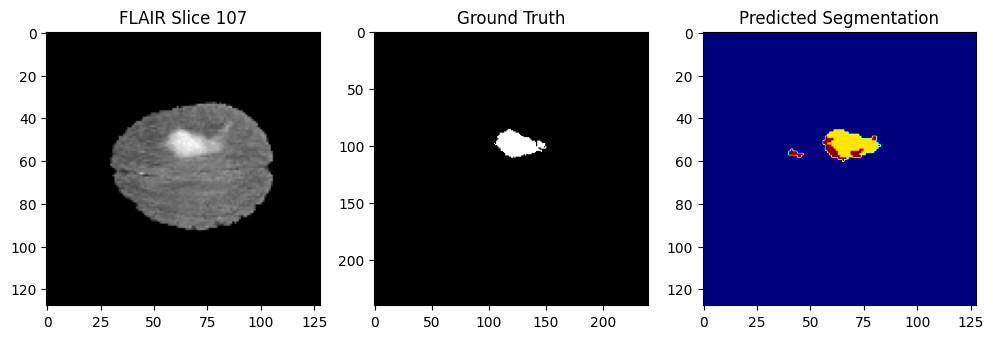

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


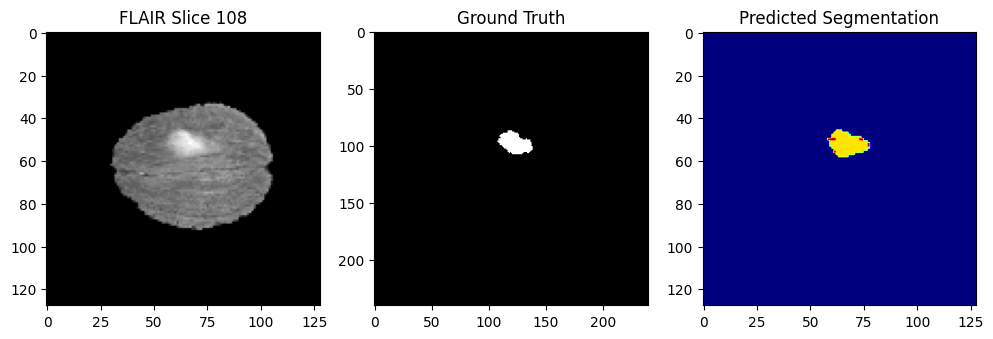

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


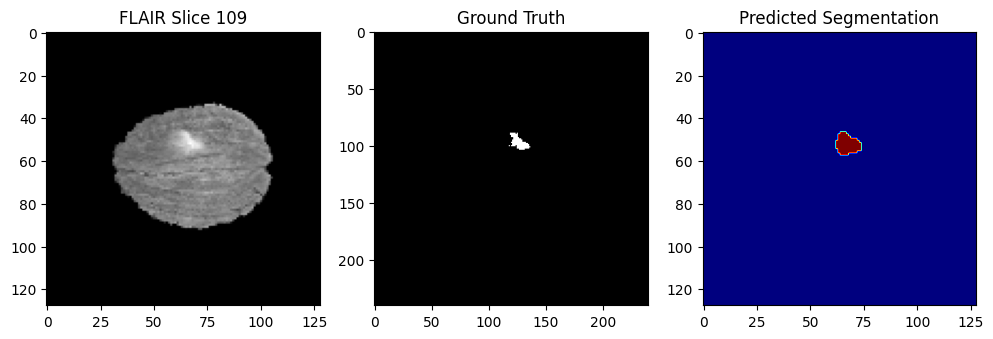

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


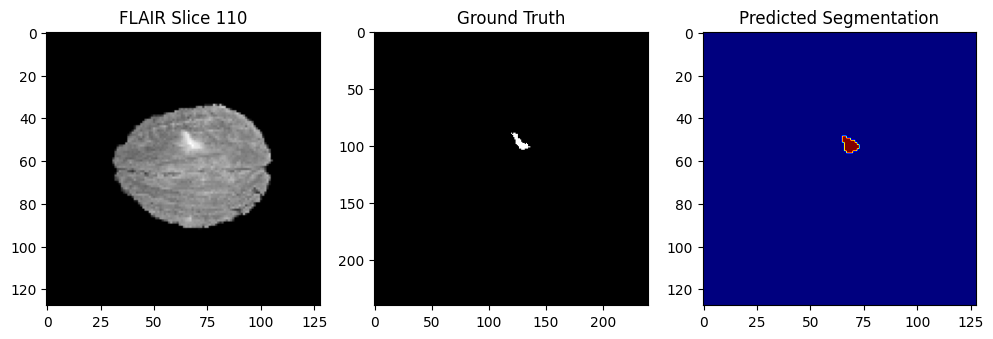

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


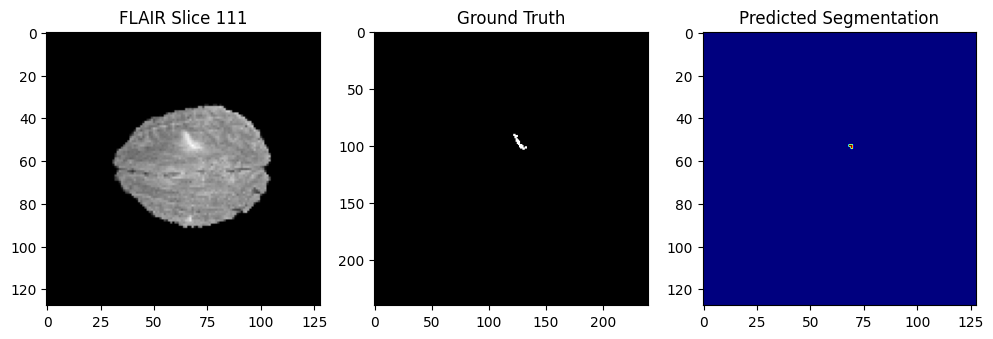

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


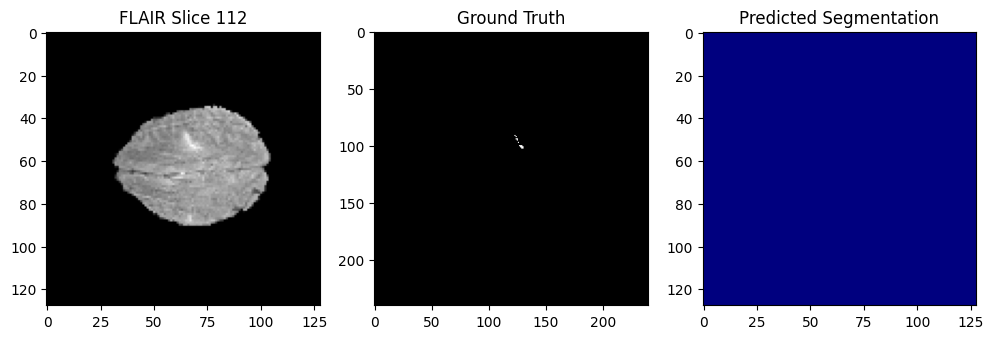

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


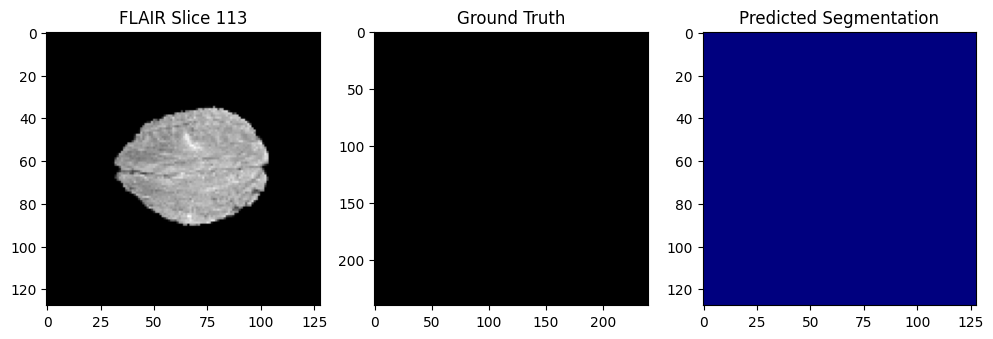

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


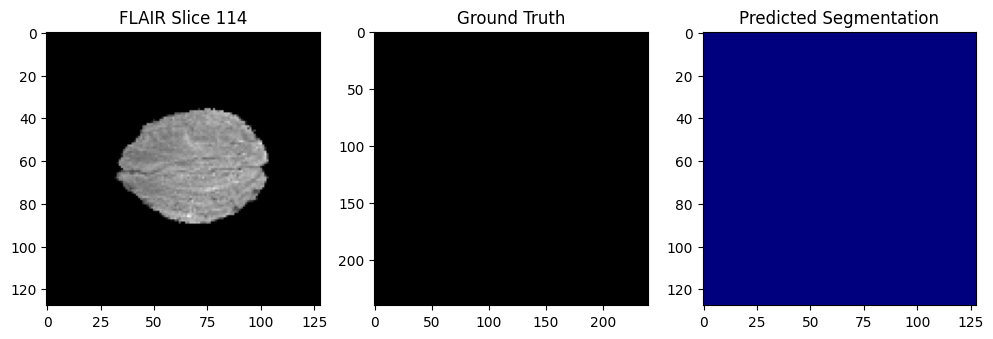

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


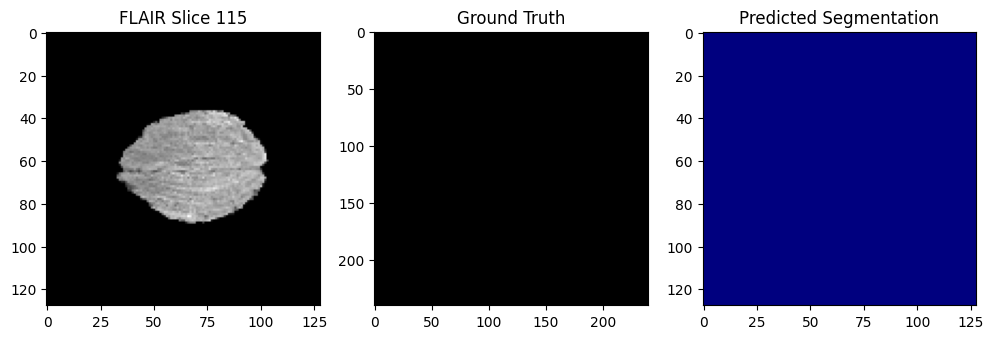

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


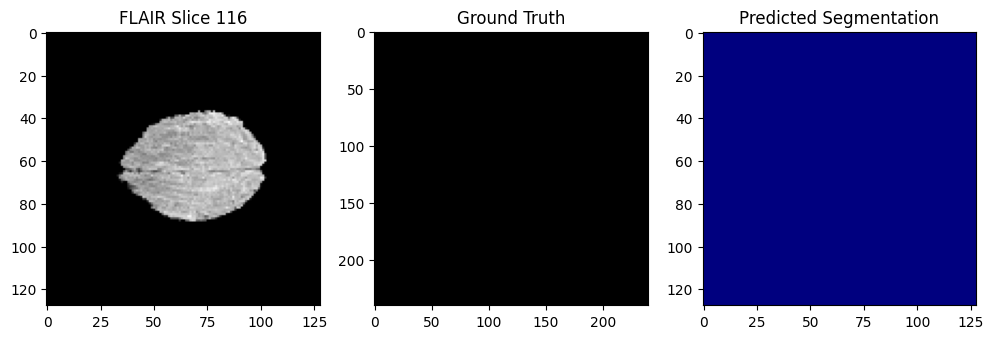

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


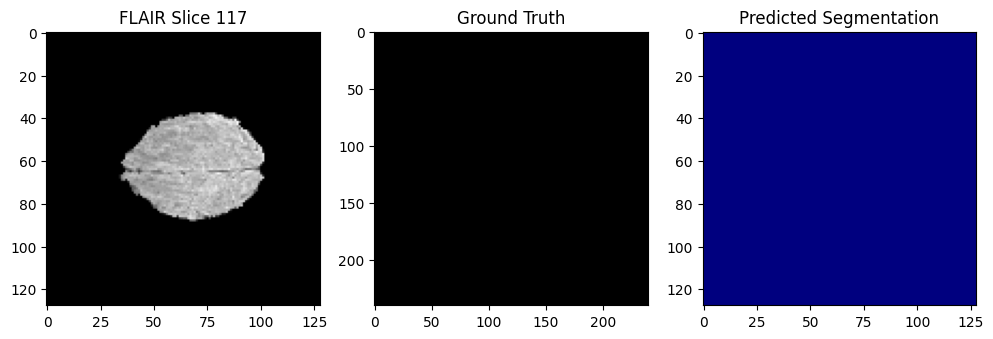

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


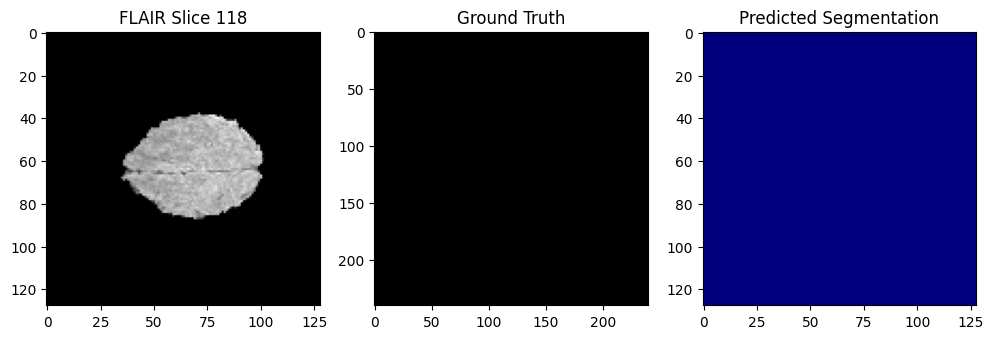

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


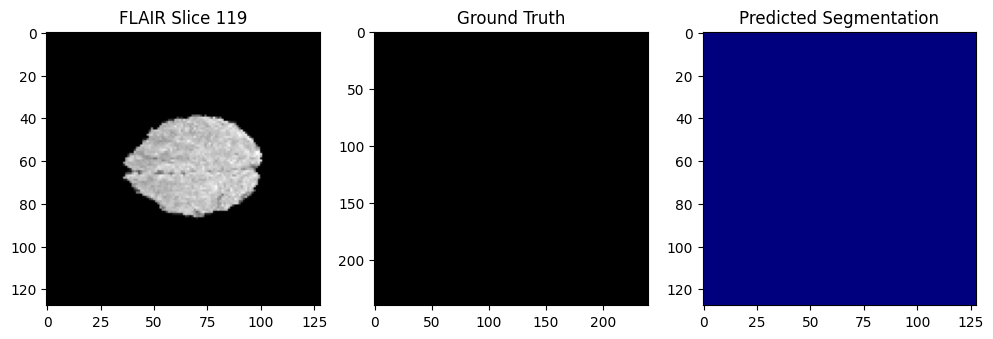

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


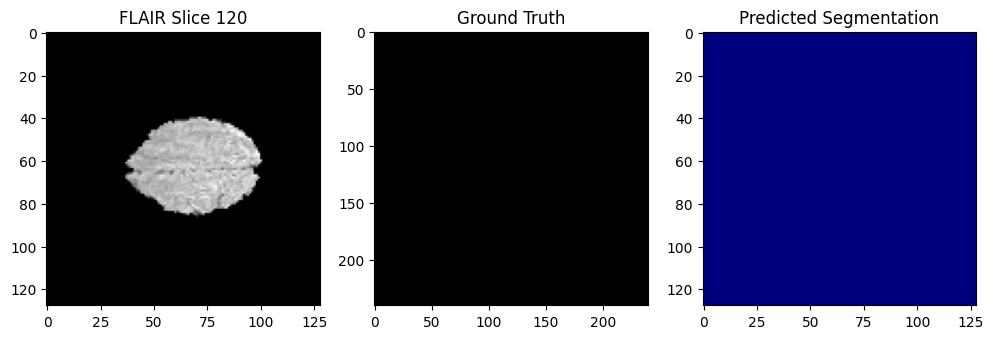

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


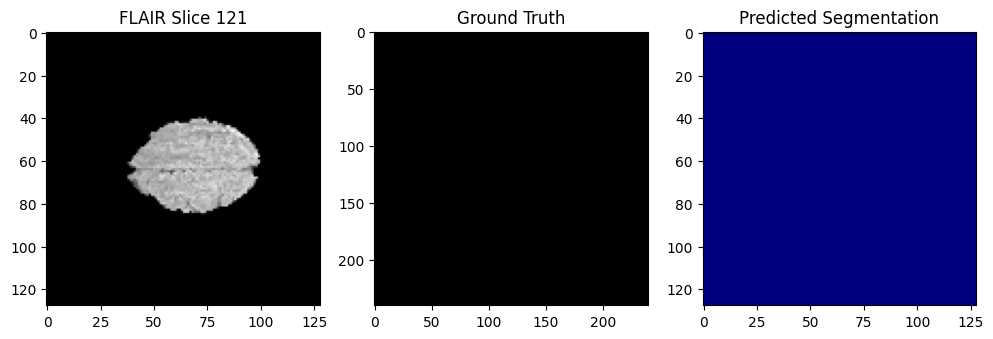

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


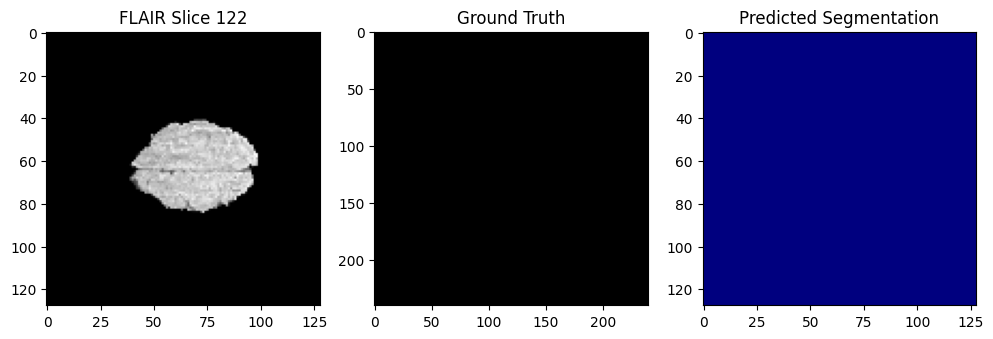

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


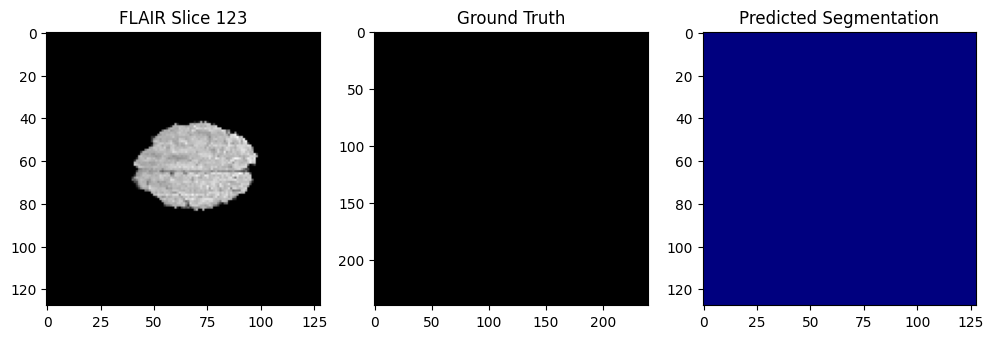

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


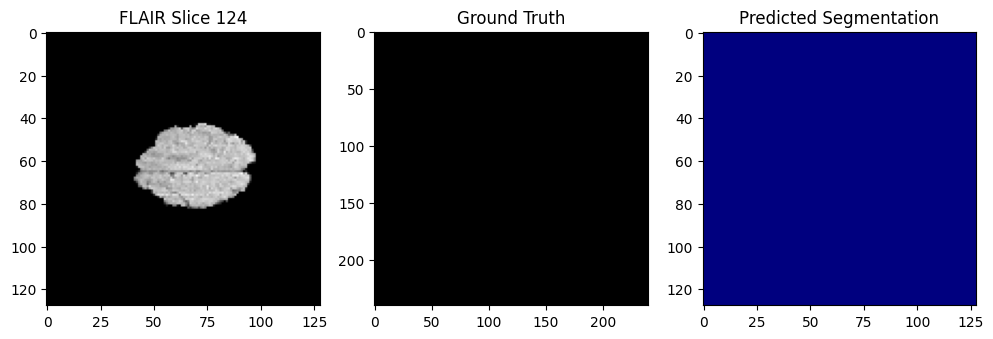

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


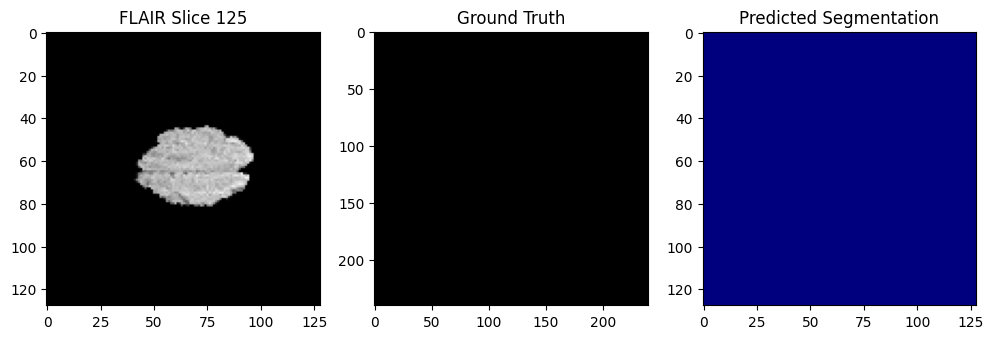

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


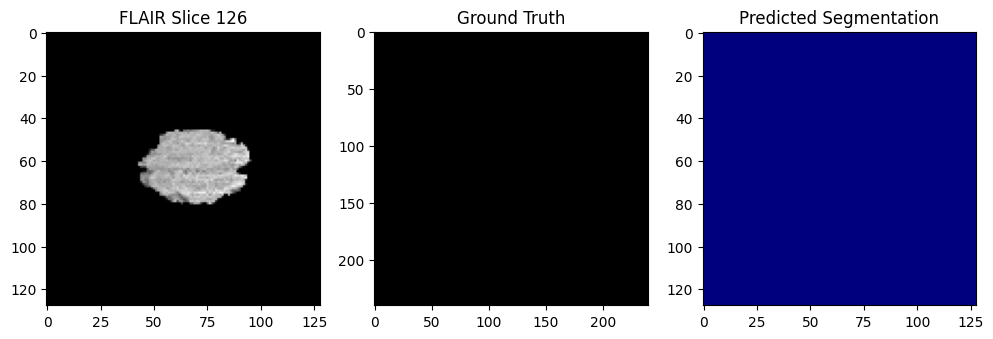

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


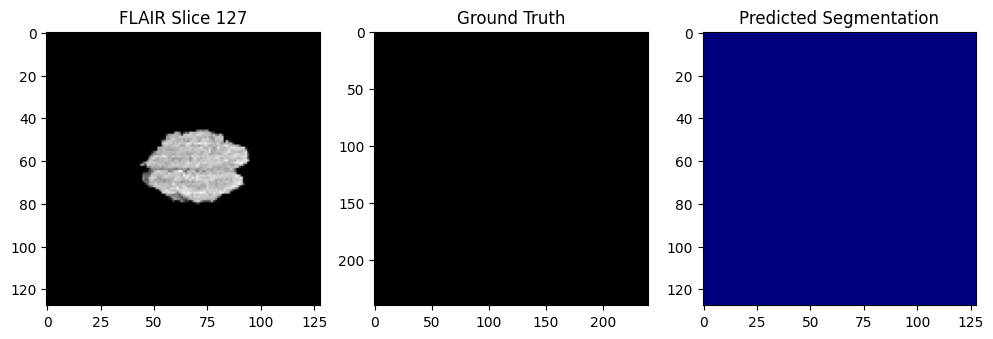

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


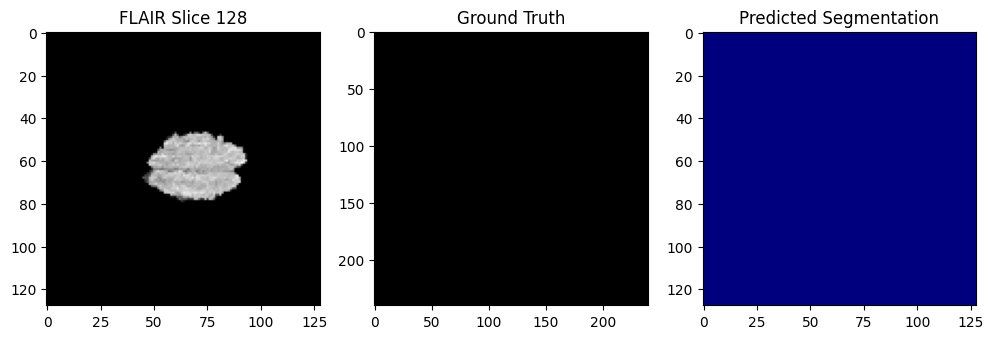

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


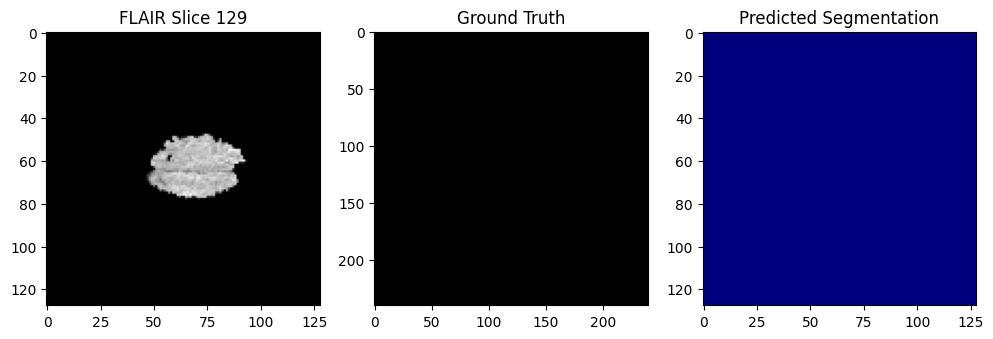

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


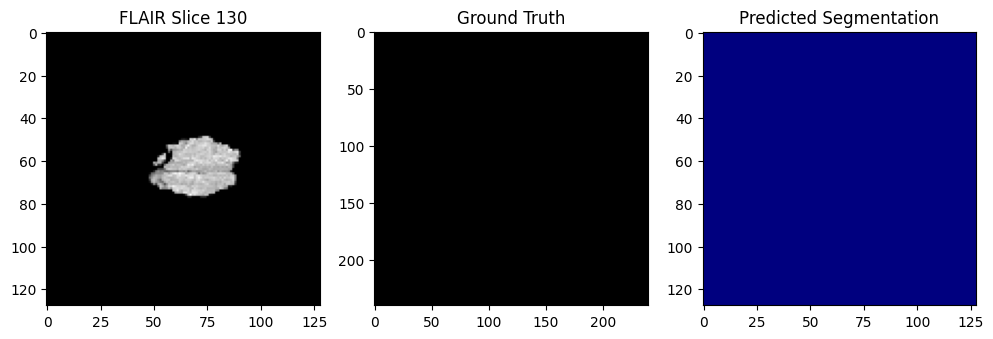

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


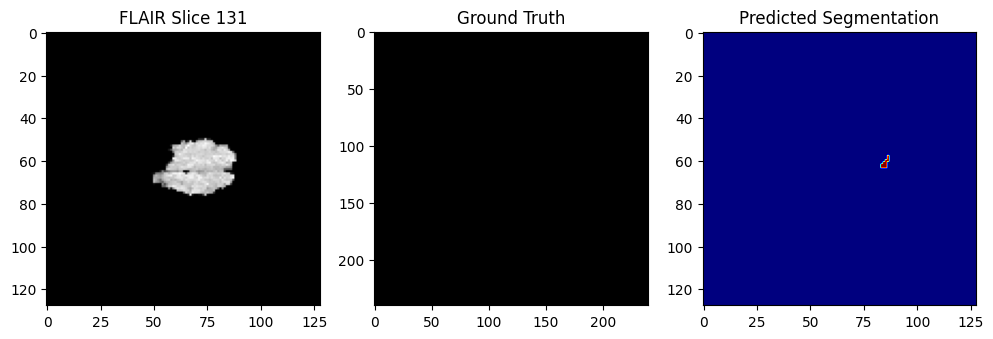

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


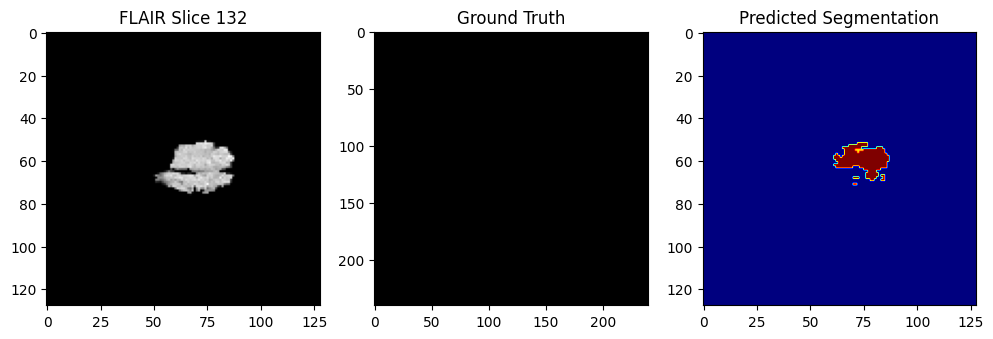

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


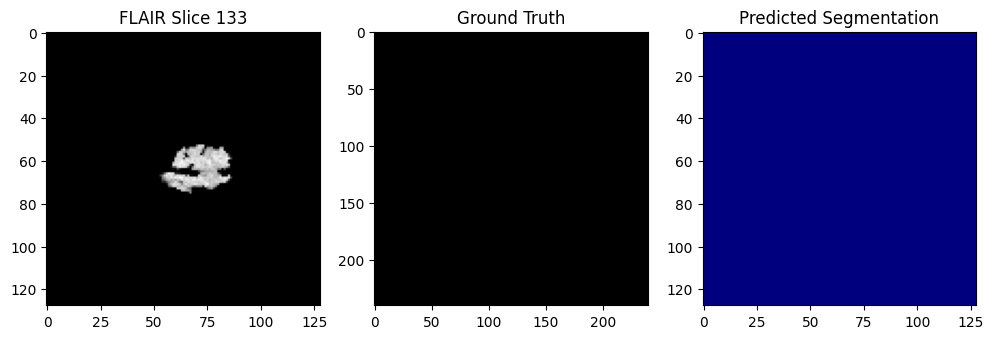

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


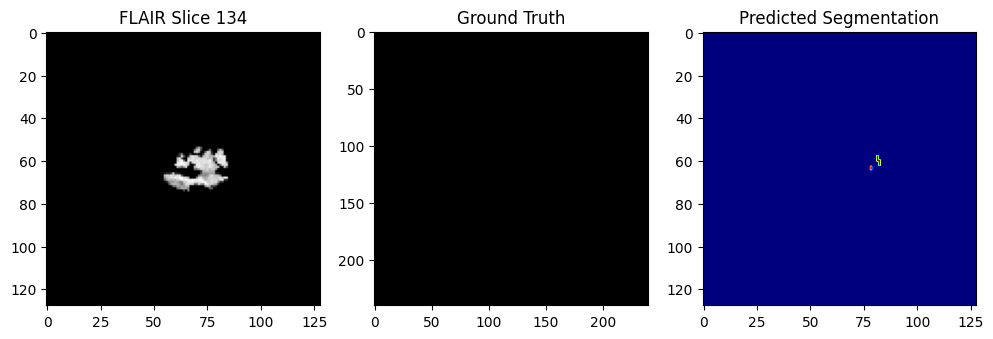

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


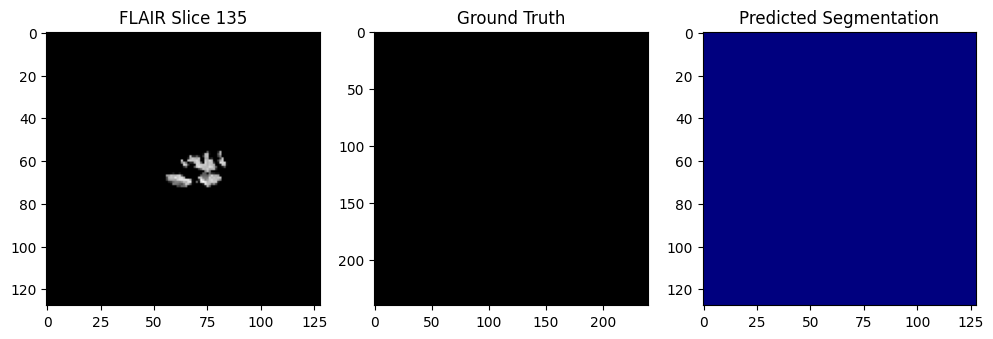

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


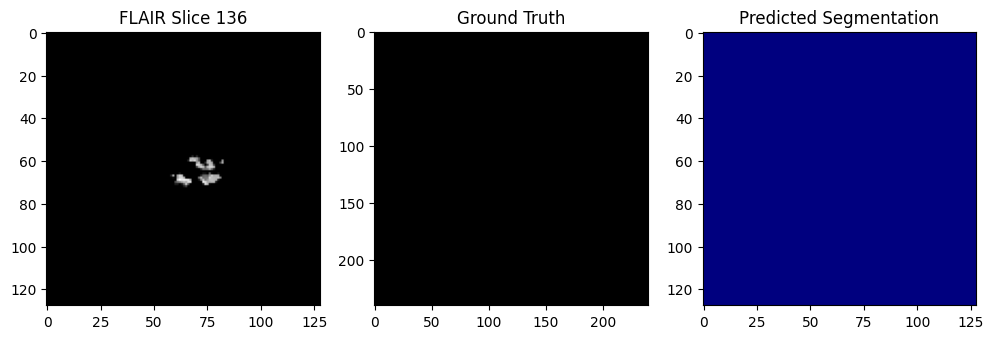

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


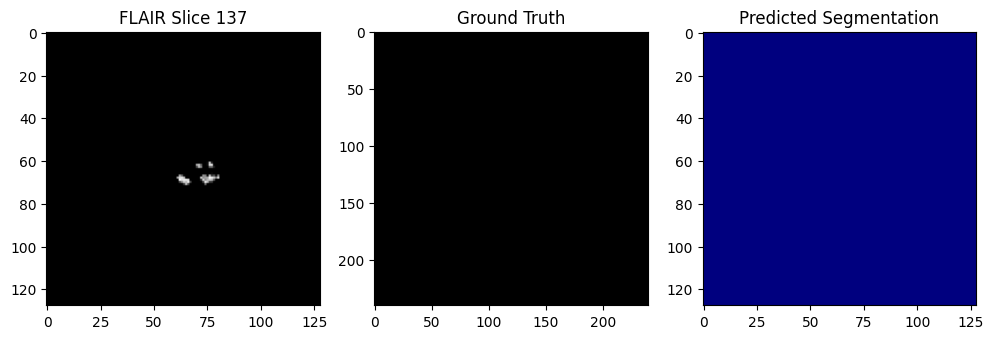

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


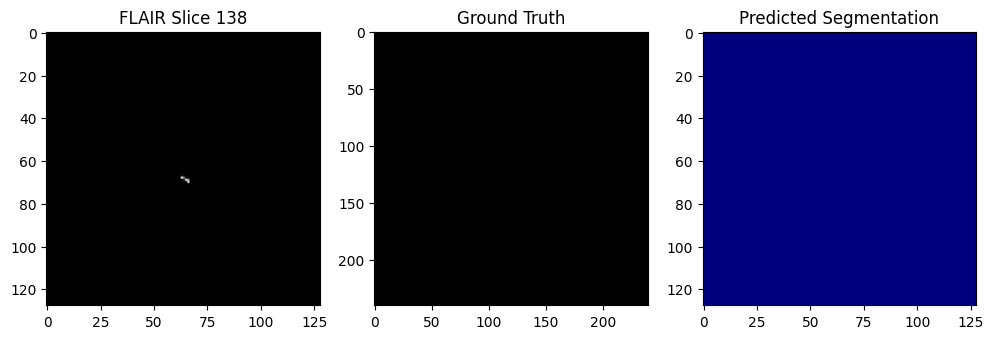

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


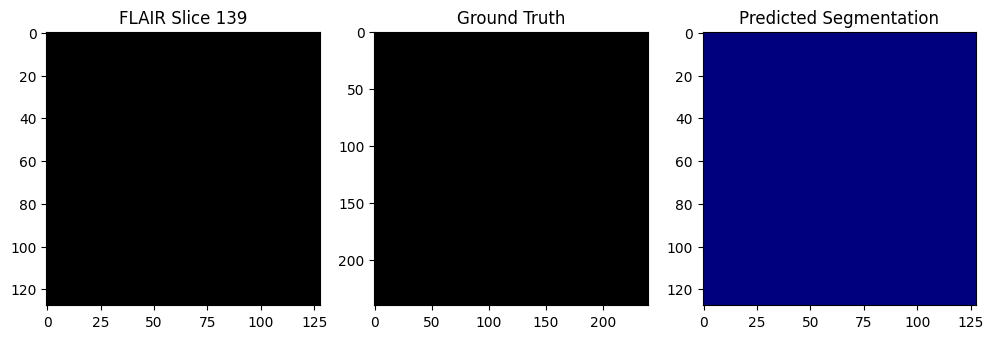

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


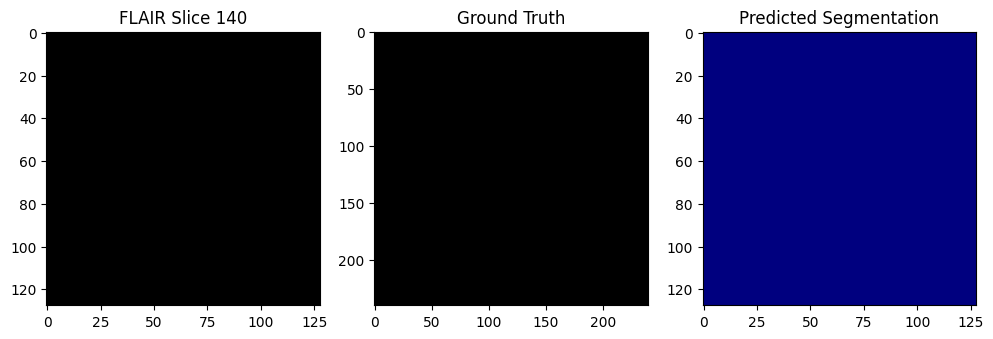

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


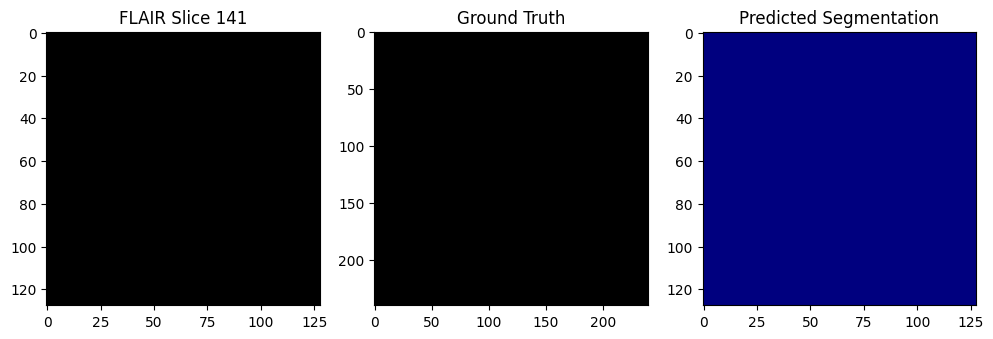

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


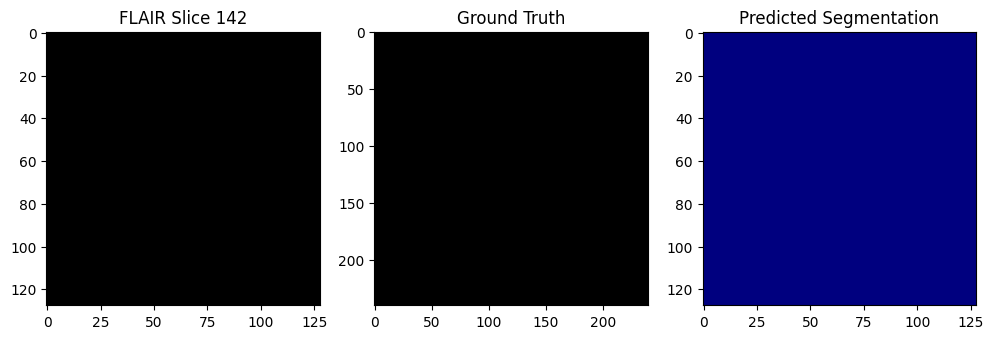

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


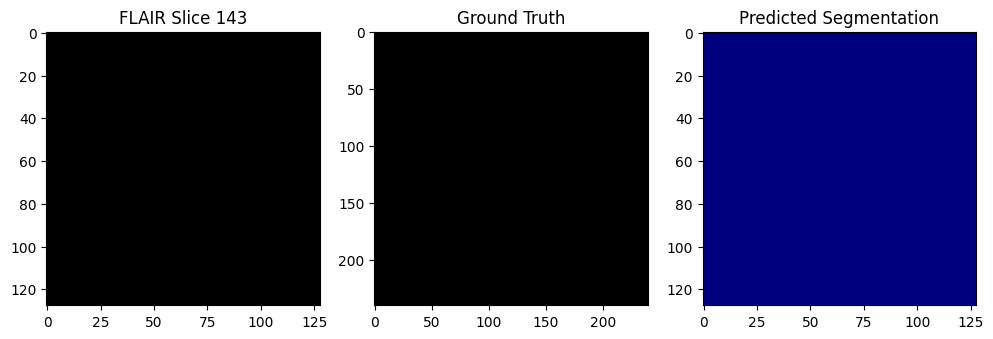

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


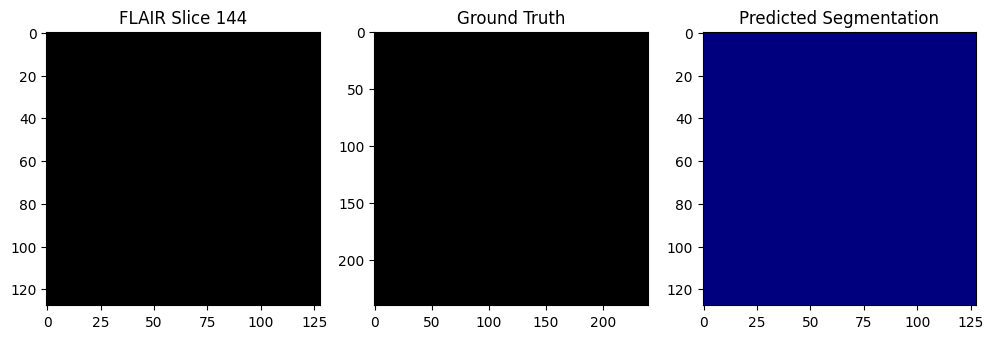

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


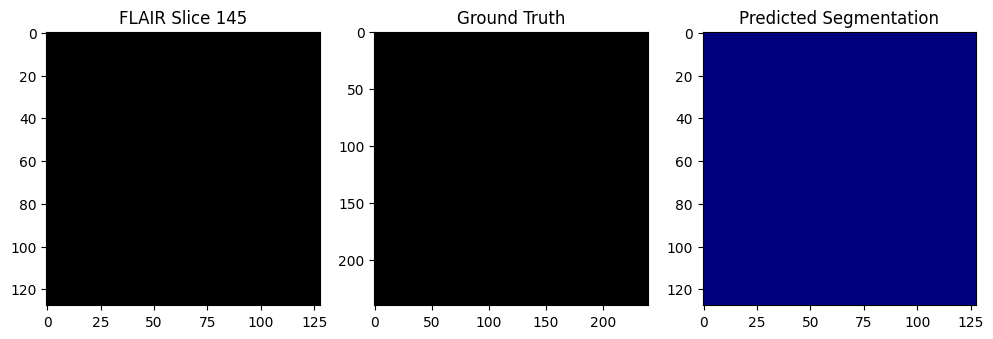

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


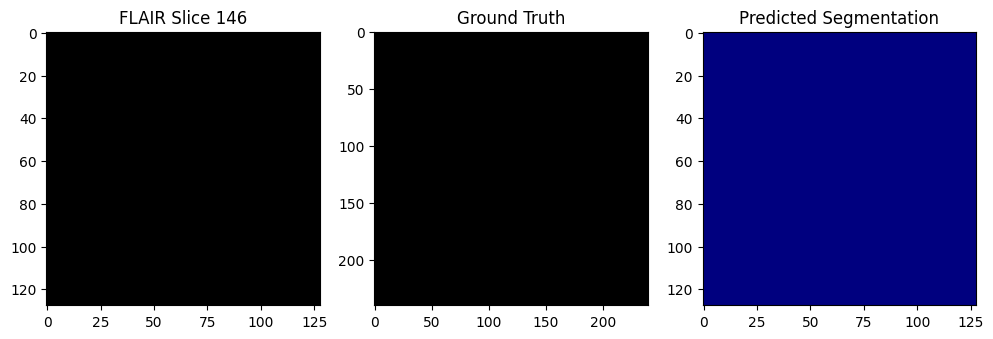

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


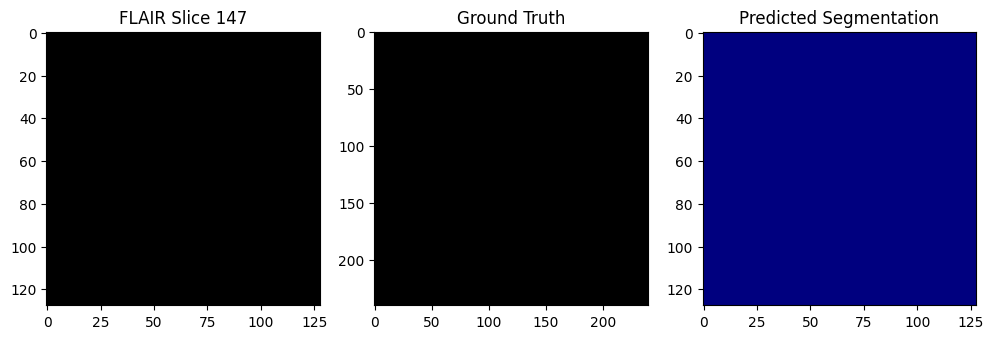

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


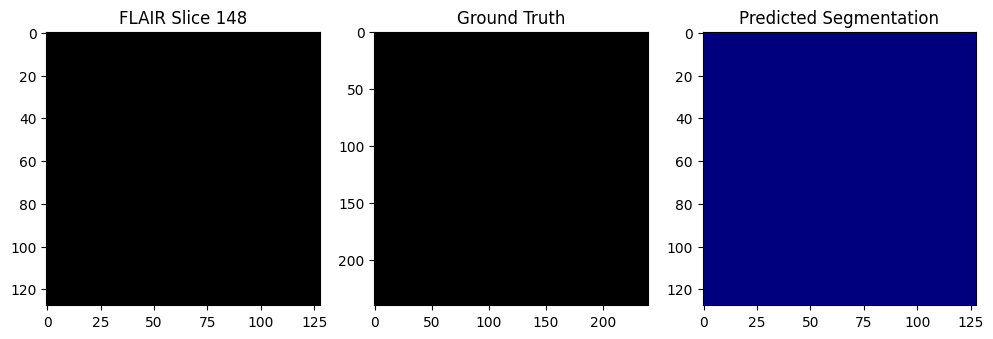

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


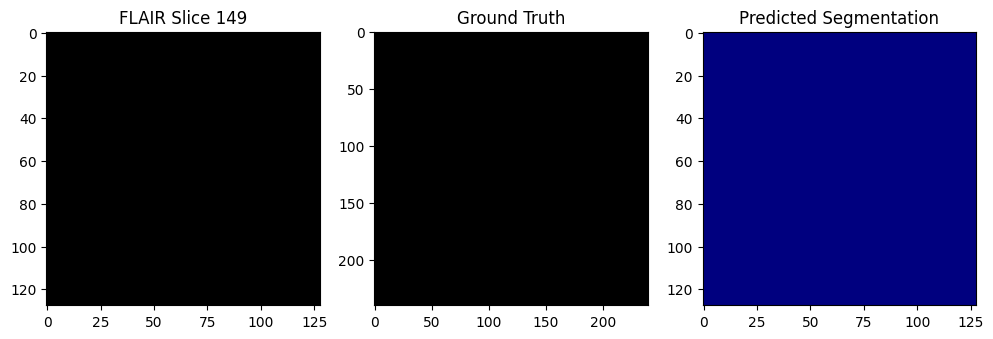

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


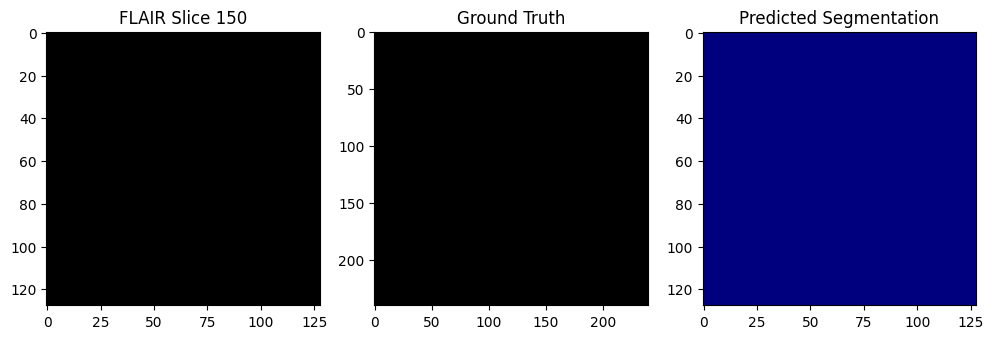

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


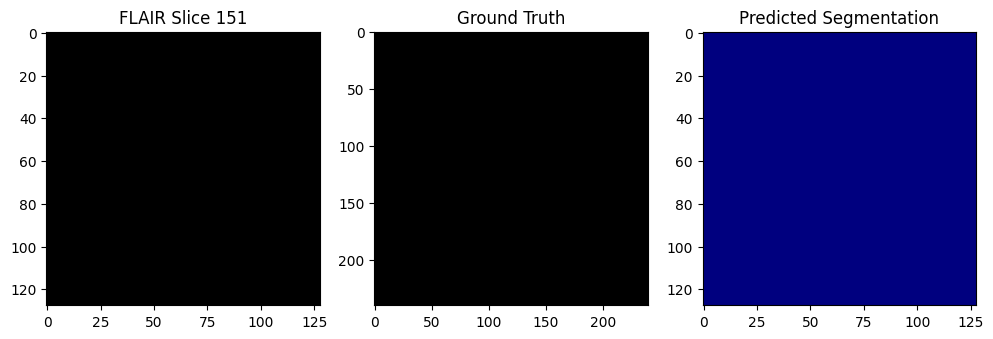

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


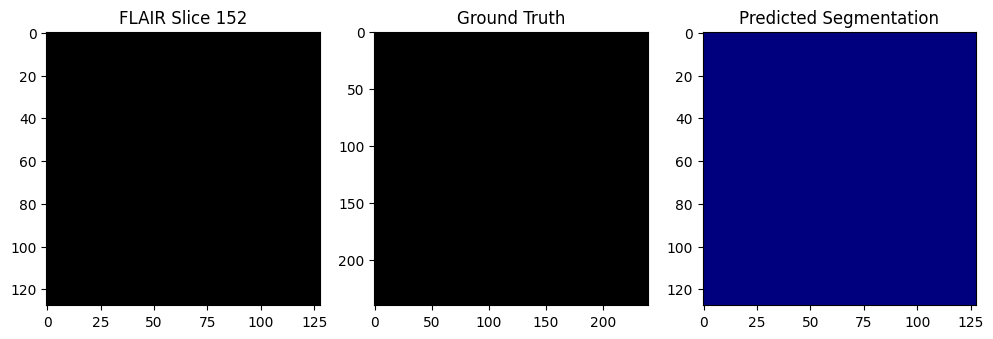

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


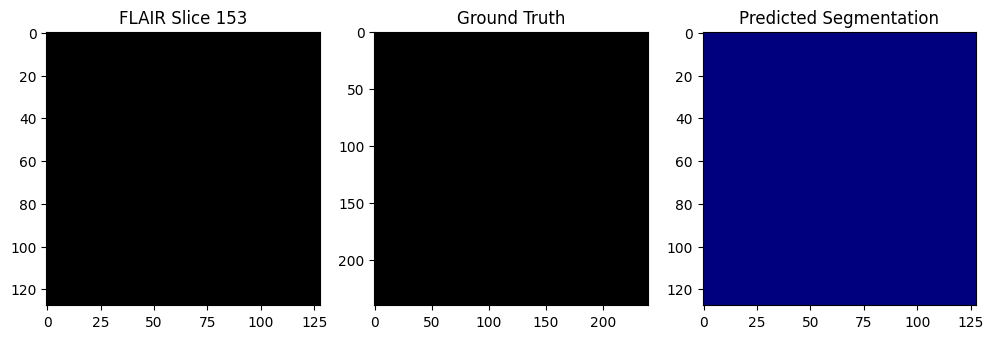

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


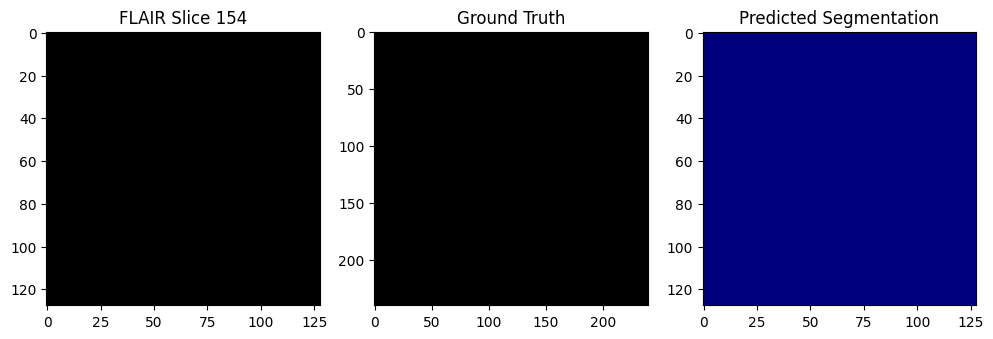

In [35]:
import numpy as np
import tensorflow as tf
import nibabel as nib
import cv2
import matplotlib.pyplot as plt


model = tf.keras.models.load_model('Brats_Seg.h5')


IMG_SIZE = 128  
VOLUME_START_AT = 0  
VOLUME_SLICES = 155  


case_id = 'BraTS20_Training_001' 
case_path = '/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/'


flair = nib.load(f'{case_path}BraTS20_Training_001_flair.nii').get_fdata()
ce = nib.load(f'{case_path}BraTS20_Training_001_t1ce.nii').get_fdata()
t1 = nib.load(f'{case_path}BraTS20_Training_001_t1.nii').get_fdata()
t2 = nib.load(f'{case_path}BraTS20_Training_001_t2.nii').get_fdata()
seg = nib.load(f'{case_path}BraTS20_Training_001_seg.nii').get_fdata()


for slice_idx in range(VOLUME_SLICES):

    flair_slice = cv2.resize(flair[:, :, slice_idx], (IMG_SIZE, IMG_SIZE))
    ce_slice = cv2.resize(ce[:, :, slice_idx], (IMG_SIZE, IMG_SIZE))


    X_single = np.stack([flair_slice, ce_slice], axis=-1)
    X_single = np.expand_dims(X_single, axis=0)  
    X_single = X_single / (np.max(X_single) + 1e-8) 


    seg_slice = seg[:, :, slice_idx]
    seg_slice = np.where(seg_slice == 4, 3, seg_slice)  
    mask = tf.one_hot(seg_slice, 4)  # One-hot encode
    mask = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))


    prediction = model.predict(X_single)

    
    pred_mask = np.argmax(prediction[0], axis=-1)

    
    plt.figure(figsize=(12, 6))

    
    plt.subplot(1, 3, 1)
    plt.imshow(X_single[0, :, :, 0], cmap='gray')
    plt.title(f'FLAIR Slice {slice_idx}')

    
    plt.subplot(1, 3, 2)
    plt.imshow(seg_slice, cmap='gray')
    plt.title('Ground Truth')

    
    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap='jet')
    plt.title('Predicted Segmentation')

    
    plt.show()


In [16]:
results = model.evaluate(test_generator)
print(f"Test results: {results}")

45/45 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.9914 - dice_coef: 0.5315 - dice_coef_edema: 0.4482 - dice_coef_enhancing: 0.4220 - dice_coef_necrotic: 0.2599 - loss: 0.0278 - mean_io_u: 0.4529 - precision: 0.9926 - sensitivity: 0.9894 - specificity: 0.9975
Test results: [0.02888013795018196, 0.9907747507095337, 0.4999997615814209, 0.5472068786621094, 0.9920921325683594, 0.9886645674705505, 0.9973184466362, 0.27746179699897766, 0.48356956243515015, 0.43179914355278015]
